## Imports

In [571]:
# Typical and standard libraries
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm as colormap
from PIL import Image

# ML and CNN functions
import keras
from keras.models import Sequential   # NN model
from keras.utils import to_categorical # one-hot encoding
from keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPooling2D, AveragePooling2D # for each layer in NN
from keras.initializers import Zeros, Ones # for kernel initialization
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split # break up data
from sklearn.metrics import confusion_matrix # evaluate models
from sklearn.utils.multiclass import unique_labels # encoding labels for evaluation

## Custom Functions

### Split data, generate more data if specified

In [591]:
# speed up splitting process.
def GenSplitNorm(data, labels, generate=True, balance=False):
    '''
    Simply split data into X, Y training and testing sets, linear transform X to center on 0, range ±0.5, 
    and one-hot encode labels
    '''
    if generate:
        # make larger spread of data using generator
        datagen = ImageDataGenerator(
            rotation_range=90,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True,
            vertical_flip=True,
            zoom_range=0.2
        )
        # make generated dataset
        gen_image = datagen.flow(data[:1000], labels[:1000], batch_size=1000)

        # generated 1000 positive images
        pos = gen_image[0][0]
        # generated 1000 positive labels
        lab = gen_image[0][1]

        # first 1000 of data are positive, next 3000 are negative
        # these commands make data and labels have 2000 of each
        if balance:
            newdata = np.concatenate([pos, data[:3000]])
            newlabels = np.concatenate([lab, labels[:3000]])
        else:
            newdata = np.concatenate([pos, data])
            newlabels = np.concatenate([lab, labels])
            
            
        # make the train/test split
        X_train, X_test, y_train, y_test = train_test_split(newdata, newlabels, random_state=20, test_size=.2)
    
    else:
        if balance:
            # split using first 2000 original data (half 1 half 0)
            X_train, X_test, y_train, y_test = train_test_split(data[:2000], labels[:2000], random_state=20, test_size=.2)
        else:
            X_train, X_test, y_train, y_test = train_test_split(data, labels, random_state=20, test_size=.2)
        
    # scale data input, must normalize around 0 to maximize use of ReLU
    if X_train.max() != 1:
        X_train = (X_train/255) - 0.5
        X_test = (X_test/255) - 0.5
        
    # one-hot encode the labels
    num_classes = len(np.unique(y_train))
    y_train = to_categorical(y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)
    
    return (X_train, X_test, y_train, y_test)

### Train model and output dictionary of results

In [596]:
# Function to make optimizing the models easier
def TrainShow(X_train, y_train,
              num_layers=0, multidense=0, nodes=20, kernel_size=3, pooling=0, dropout=0.25, epochs=10,
              loss='categorical_crossentropy', optimizer='adam', activationIn='relu', activationOut='softmax',
              padding='valid', random_state=0, savefile='weightsave.h5', init_kernel=False, oneweight=1
             ):
    '''
    Wrapper that takes image data and labels, runs CNN shallow learning algorithm fit, and returns
    a dictionary containing the model and model performance data. 
    
    Input data must be formatted with dimensions (batch, rows, cols, channels), labels must not be one-hot encoded
    
    Model structure: Conv2D -> (opt. Pooling) -> (opt. Dropout) -> (opt. repeat num_layers times...)
                -> Flatten -> (opt. multidense Dense layers) -> output Dense layer
    '''
    
    # instantiate model -----------------------------------------------
    model = Sequential()
    
    # establish class weights, get number of classes, defaults to same weights for both classes
    class_weight = {
        0:1,
        1:oneweight
    }
    num_classes = len(np.unique(y_train))
    
    # kernel initializer for consistent testing, forcing scenarios
    if init_kernel == 'zeros':
        kernel_initializer = Zeros()
    elif init_kernel == 'ones':
        kernel_initializer = Ones()
    else:
        # default kernel per documentation
        kernel_initializer = 'glorot_uniform'
        
    # assemble model -----------------------------------------------
    # Model structure: Conv2D -> (opt. Pooling) -> (opt. Dropout) -> (opt. repeat num_layers times...)
    #            -> Flatten -> (opt. multidense Dense layers) -> output Dense layer
    
    # input -- if init_kernel then use the kernel_initializer
    InputLayer = Conv2D(
        nodes, 
        activation=activationIn, 
        kernel_size=kernel_size,
        kernel_initializer=kernel_initializer,
        input_shape=X_train.shape[1:4],
        data_format='channels_last',
        padding=padding
    )
    model.add(InputLayer)
    
    # pooling optional
    if pooling:
        model.add(MaxPooling2D(pool_size=(2, 2)))

    # dropout optional
    if dropout:
        model.add(Dropout(dropout, seed=random_state))
        
    # multiple layers option, re-uses hyperparameter setting, not designed for fine-tuning
    for layer_num in range(num_layers):
        # assemble model
        model.add(Conv2D(
            nodes,
            activation=activationIn, 
            kernel_size=kernel_size,
            kernel_initializer=kernel_initializer,
            input_shape=X_train.shape[1:4],
            data_format='channels_last',
            padding=padding
        ))

        # only add pooling layers if there is a value (max or avg)
        # pooling optional
        if pooling:
            model.add(MaxPooling2D(pool_size=(2, 2)))

        # dropout optional
        if dropout:
            model.add(Dropout(dropout, seed=random_state))
    
    
    # flatten 3D arrays (includes channels) and feed to dense layer(s)
    model.add(Flatten())
    
    # multiple dense layers
    for i in range(multidense):
        model.add(Dense(round((80**2) * (0.5**(num_layers + 1))), activation=activationIn))
    
    # output dense layer
    model.add(Dense(2, activation=activationOut))
    
    # compile model -----------------------------------------------
    model.compile(
        loss=loss,
        optimizer=optimizer, 
        metrics=['accuracy']
    )
    
    print(model.summary())
    
    # fit model and store epoch loss/accuracy information
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        validation_split=0.25, # 25% of 80% -> 20% for validation, 60% to train
        shuffle=True,
        verbose=1
    )

    # store weights
    model.save(savefile)
    
    print('done fitting model.')
    
    output = {
        'model':model,
        'model_loss_list':history.history['loss'],
        'model_acc_list':history.history['acc'],
        'prediction_loss':history.history['val_loss'],
        'prediction_acc':history.history['val_acc']
    }
    
    return output

### Plot the results from a dictionary of training dictionaries

In [572]:
def PlotResults(outputs):
    '''
    Plots the output (training history) of models from dictionary made by TrainShow().
    '''
    # set up fonts
    font = {
        'family':'sans-serif',
        'sans-serif':['Helvetica'],
        'size'   : 16
    }
    plt.rc('font', **font)
    
    # loop over dictionary and colors to make plots
    fig, ax = plt.subplots(2, 3, figsize=(30, 20))
    
    # make color spectrum
    colors = colormap.get_cmap('gist_rainbow', len(outputs.values()))
    
    # loop over output dictionaries in outputs
    for output, label, c in zip(outputs.values(), outputs.keys(), range(len(outputs.values()))):
        # simplify code for readability
        train_loss = output['model_loss_list']
        train_acc = output['model_acc_list']
        test_loss = output['prediction_loss']
        test_acc = output['prediction_acc']
        
        # make training loss plot
        ax[0, 0].plot(range(1, len(train_loss)+1),
                   train_loss,
                   c=colors(c),
                   label=label
        )
        # make testing loss plot
        ax[0, 1].plot(range(1, len(test_loss)+1),
                   test_loss,
                   c=colors(c),
                   label=label
        )
        # make training accuracy plot
        ax[1, 0].plot(range(1, len(train_acc)+1),
                   train_acc,
                   c=colors(c),
                   label=label
        )
        # make testing accuracy plot
        ax[1, 1].plot(range(1, len(test_acc)+1),
                   test_acc,
                   c=colors(c),
                   label=label
        )
    # add titles and legends
    for axlist in ax:
        for plot in axlist:
            plot.set_xlabel('Epoch')
            plot.set_yticks([i * 0.10 for i in range(0,11)])
            plot.set_ylim(bottom=0, top=1)
            plot.grid(True)
    ax[0, 2].set_axis_off()
    ax[1, 2].set_axis_off()
    ax[0, 1].legend(loc='center left', bbox_to_anchor=(1, 0))
    ax[0, 0].set_title('Training Loss')
    ax[0, 1].set_title('Test Loss')
    ax[1, 0].set_title('Training Accuracy')
    ax[1, 1].set_title('Test Accuracy')
    
    plt.show()

### Make confusion matrix, if errors look good plot it, output success count

In [601]:
# straight from sklearn documentation/examples, slightly adapted
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # normalize matrix and evaluate 
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
    print(cm)
    if (cm[1, 0] > 0.1) & (cm[0, 1] > 0.1):
        print('Errors too high! Probably a bad model.')
        return 0
    if (cm[1, 0] > 0.1):
        print('False negatives too high! Probably a bad model.')
        return 0
    if (cm[0, 1] > 0.1):
        print('False positives too high! Probably a bad model.')
        return 0

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()
    return 1

def EvaluateAndPlot(outputs, X_test, y_test, count=True):
    
    # argmax undoes one-hot encoding
    y_test = y_test.argmax(1)
    
    # make counter dictionaries
    activations = {}
    optimizers = {}
    lossers = {}
    
    if count:
        # start counters
        for label in list(outputs.keys()):
            activation, optimizer, loss = label.split('-')
            activations[activation] = 0
            optimizers[optimizer] = 0
            lossers[loss] = 0
    
    # loop over dictionary
    for (label, output) in outputs.items():
        print('-'*20, label, '-'*20)
        # predict using model from output dictionary
        y_pred = output['model'].predict(X_test)
        # argmax undoes one-hot encoding
        y_pred = y_pred.argmax(1)
        success = plot_confusion_matrix(y_test, y_pred, ['no ship', 'ship'], normalize=True, title=label)

        if count:
            # success returns 0 or 1, add to counters for each component of model
            activation, optimizer, loss = label.split('-')
            activations[activation] += success
            optimizers[optimizer] += success
            lossers[loss] += success
    
    return (activations, optimizers, lossers)

## Load Data

In [5]:
# make data dictionary then close file
with open('shipsnet.json') as datafile:
    data_dict = json.load(datafile)

## Reshape Data

In [102]:
# data has dimensions (4000, 19200), with 6400 data points for each color (rgb) in a row.
# Breaking it down into 4000 sets of three colors of 80 x 80 pixle images, transpose to work with plt.imshow()
data = np.reshape(data_dict['data'], (-1, 3, 80, 80)).transpose([0, 2, 3, 1])
labels = np.array(data_dict['labels'])
locations = np.array(data_dict['locations'])
scene_ids = np.array(data_dict['scene_ids'])

# Output results of reshape/casting
print(data.shape, type(data[0][0][0][0]))
print(labels.shape, type(labels[0]))
print(locations.shape, type(locations[0][0]))
print(scene_ids.shape, type(scene_ids[0]))

(4000, 80, 80, 3) <class 'numpy.int64'>
(4000,) <class 'numpy.int64'>
(4000, 2) <class 'numpy.float64'>
(4000,) <class 'numpy.str_'>


In [607]:
X_train, X_test, y_train, y_test = GenSplitNorm(data, labels, generate=False, balance=False)

In [610]:
# check for approximately even split of 0 and 1 labels
display(np.bincount(y_train[:,0].astype('uint8')))

array([ 788, 2412])

## Single Run - unit testing functions

In [611]:
singleton = TrainShow(
                X2_train, y2_train,
                kernel_size=4,
                activationIn='relu', 
                optimizer='adam',
                loss='categorical_crossentropy',
                savefile=f'singleton.h5',
                random_state=42,
                nodes=25,
                epochs=20,
                num_layers=2,
                multidense=1,
                dropout=0.25,
                pooling=True
            )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_262 (Conv2D)          (None, 77, 77, 25)        1225      
_________________________________________________________________
max_pooling2d_241 (MaxPoolin (None, 38, 38, 25)        0         
_________________________________________________________________
dropout_210 (Dropout)        (None, 38, 38, 25)        0         
_________________________________________________________________
conv2d_263 (Conv2D)          (None, 35, 35, 25)        10025     
_________________________________________________________________
max_pooling2d_242 (MaxPoolin (None, 17, 17, 25)        0         
_________________________________________________________________
dropout_211 (Dropout)        (None, 17, 17, 25)        0         
_________________________________________________________________
conv2d_264 (Conv2D)          (None, 14, 14, 25)        10025     
__________

KeyboardInterrupt: 

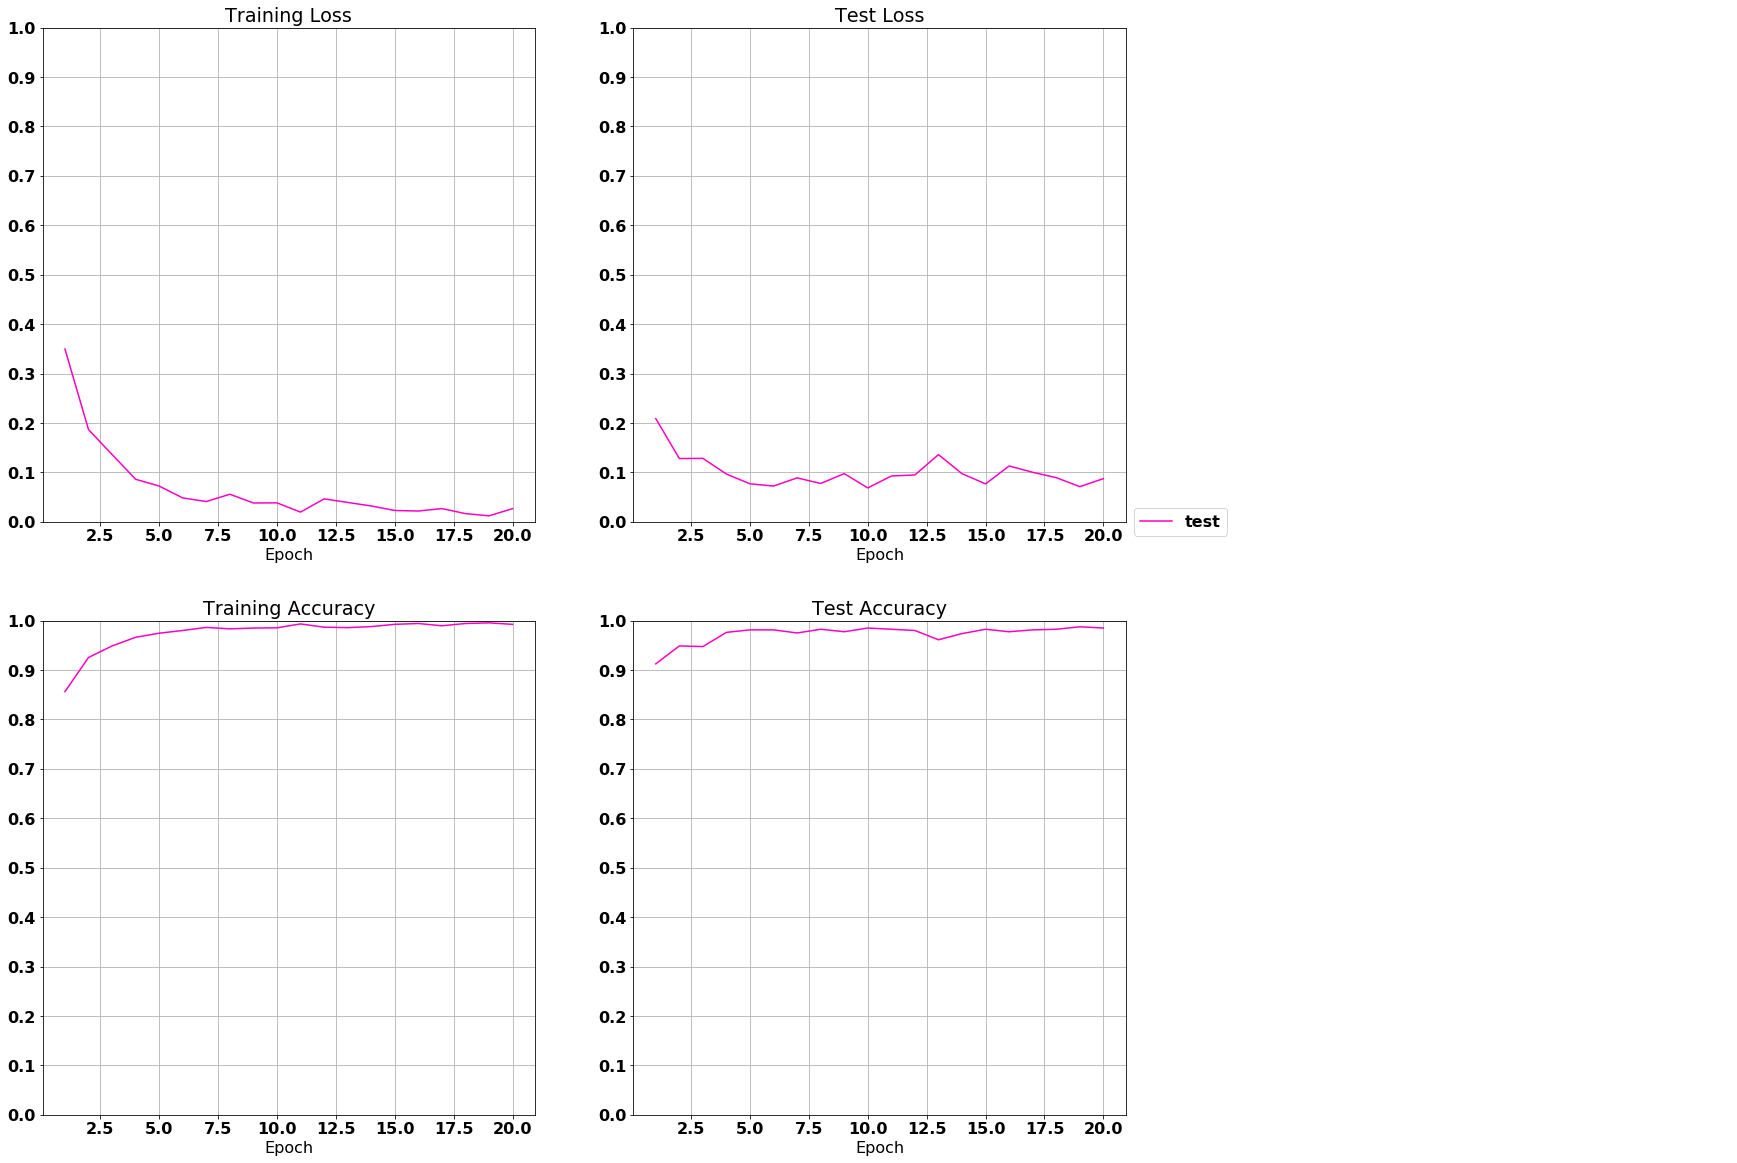

In [604]:
PlotResults({'test':singleton})

## Test various cominations of functions (60 total)

In [323]:
outputs = {}

# what to try. Not messing with individual parameters like leaky relu or sgd decay
activations = ['relu', 'elu', 'tanh', 'hard_sigmoid']
lossers = ['categorical_crossentropy', 'mean_squared_error', 'categorical_hinge']
optimizers = ['adam', 'adagrad', 'nadam', 'sgd', 'rmsprop']
# 4 act. * 3 loss * 5 opt. = 60 models

# make/split data
(X_train, X_test, y_train, y_test) = GenSplitNorm(data, labels)

# loop over options and train for 20 epochs each
for activation in activations:
    for loss in lossers:
        for optimizer in optimizers:
            print('-----------------------', activation, optimizer, loss, '-----------------------')
            # assign output to dictionary with function used as key
            outputs[f'{activation}-{optimizer}-{loss}'] = TrainShow(
                X_train, X_test, y_train, y_test, 
                activationIn=activation, 
                optimizer=optimizer,
                loss=loss,
                savefile=f'{activation}-{optimizer}-{loss}save.h5',
                random_state=42,
                epochs=20,
                num_layers=2,
                multidense=1,
                dropout=0.25,
                pooling=True
            )

----------------------- relu adam categorical_crossentropy -----------------------
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_70 (Conv2D)           (None, 78, 78, 20)        560       
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 39, 39, 20)        0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 39, 39, 20)        0         
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 37, 37, 20)        3620      
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 18, 18, 20)        0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 18, 18, 20)        0         
___________________________________________________________

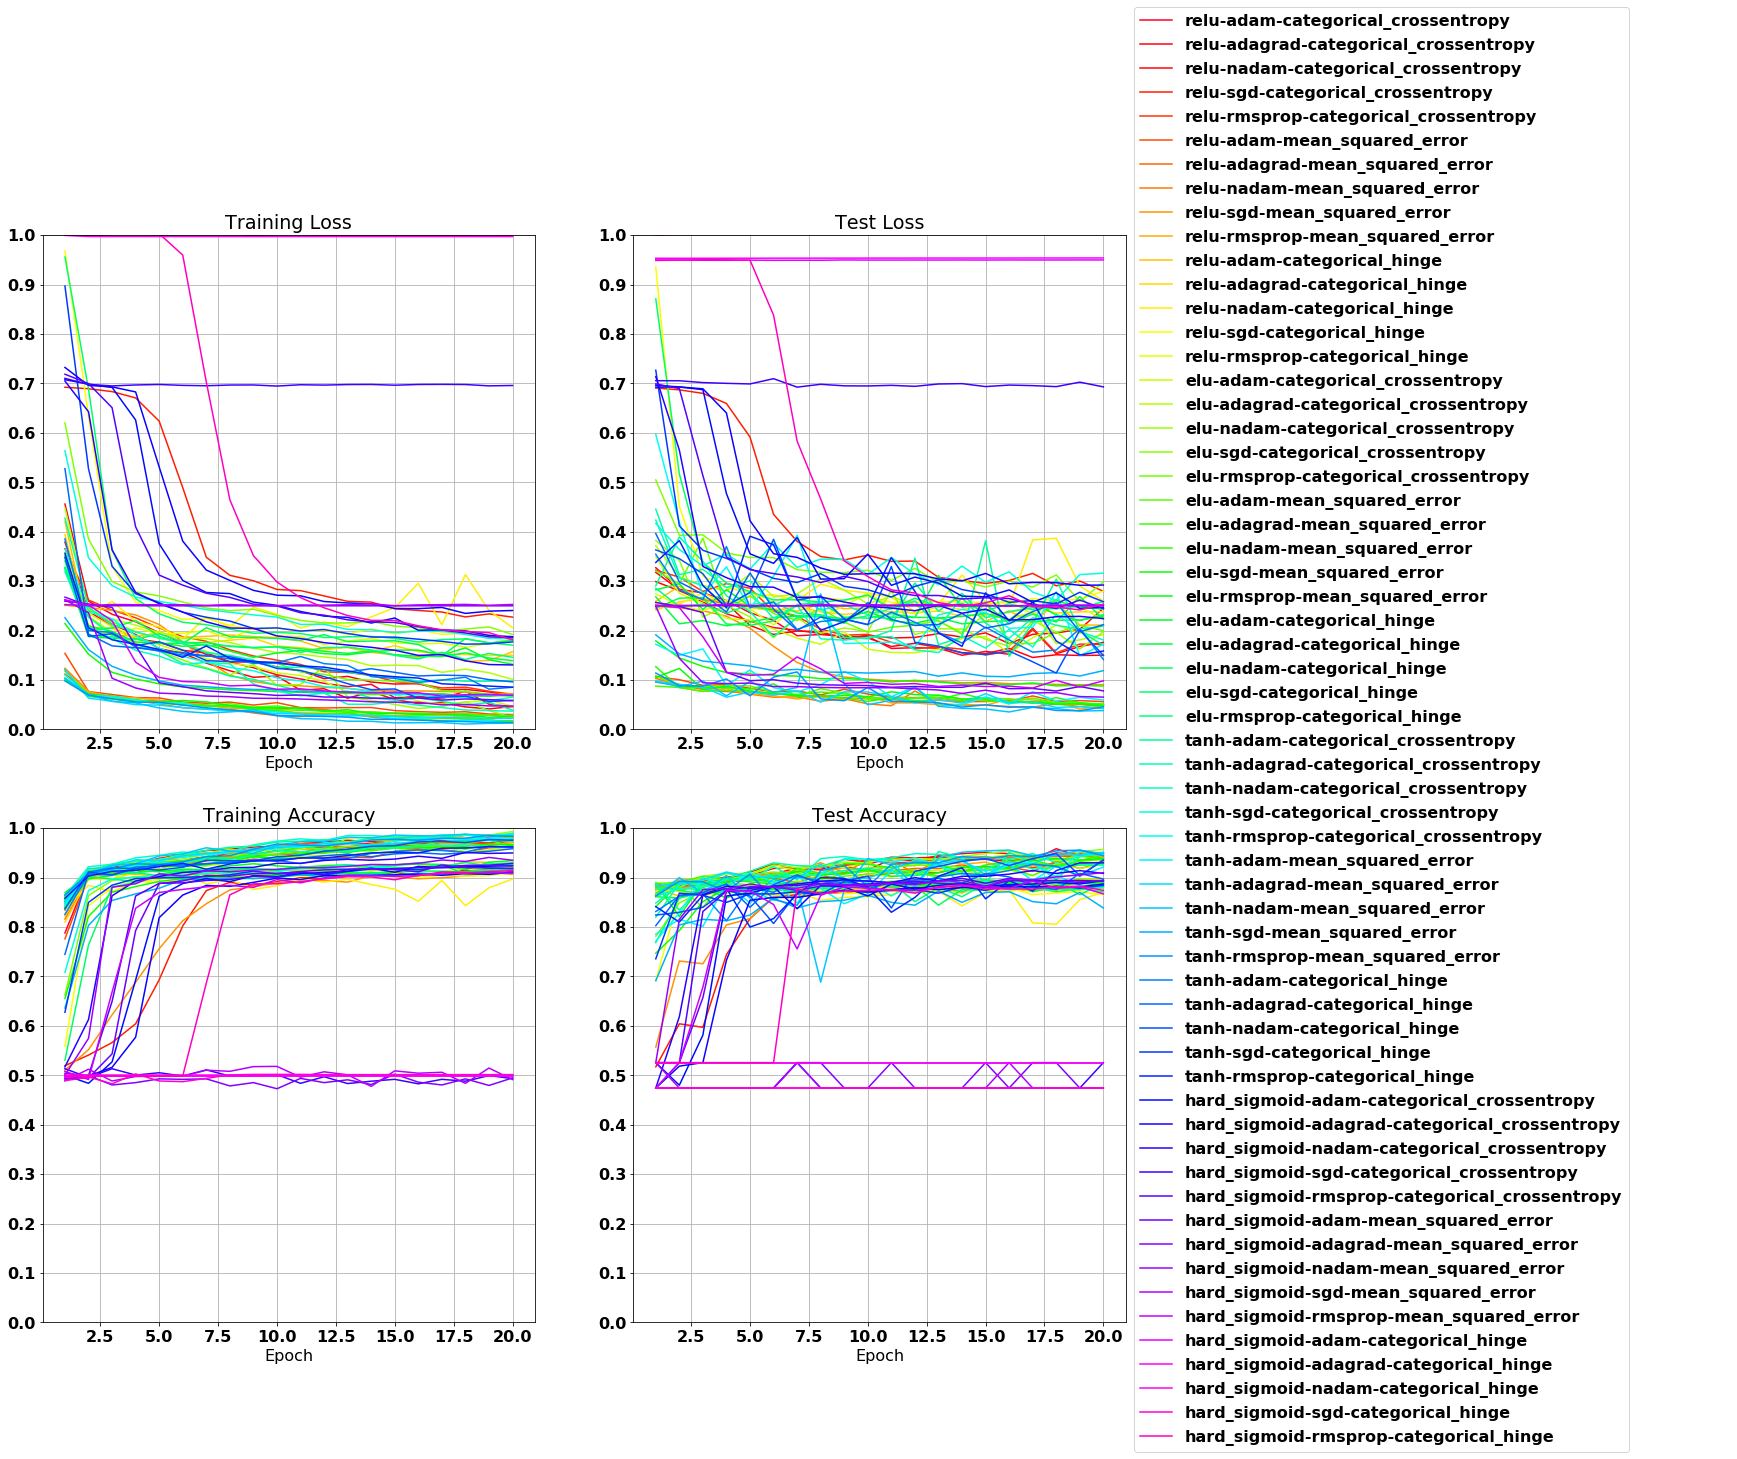

In [418]:
PlotResults(outputs)

--------------- Loss groups ---------------
--------------- categorical_crossentropy ---------------


/anaconda3/envs/machineLearning/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


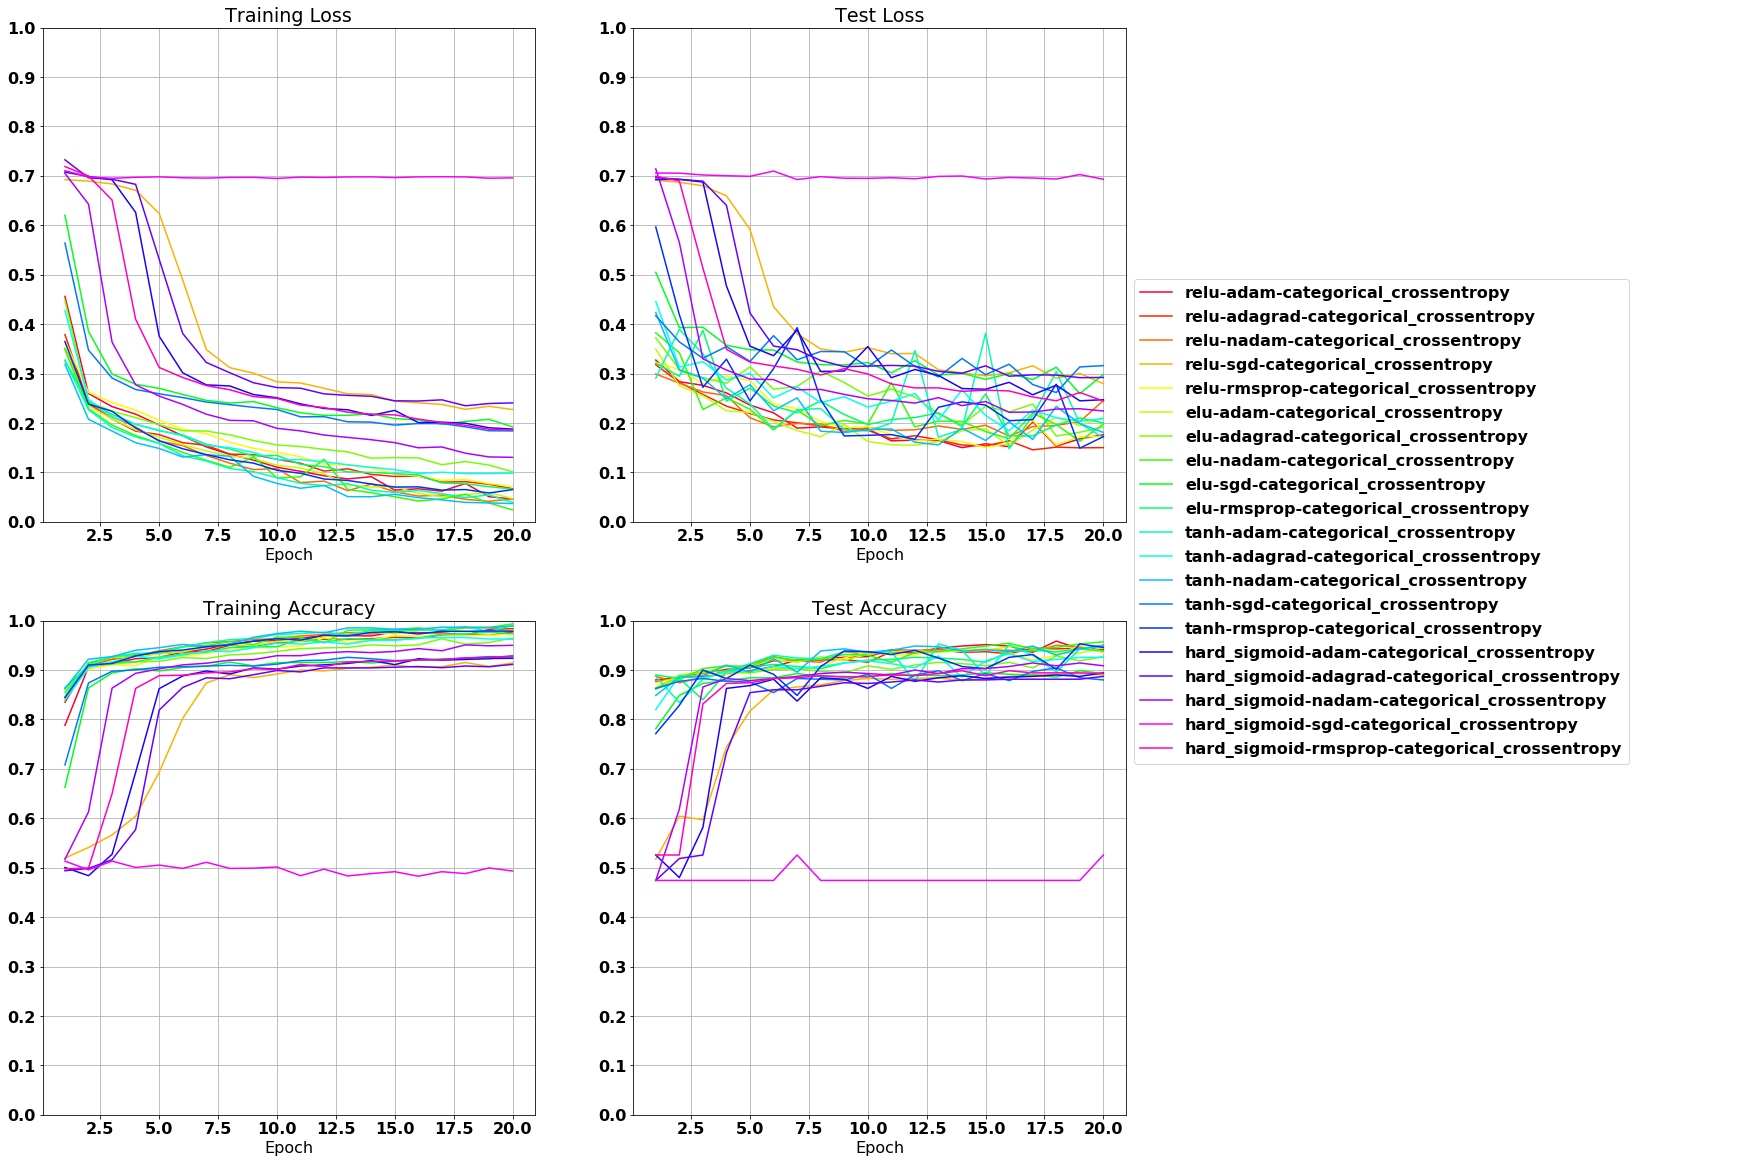

--------------- mean_squared_error ---------------


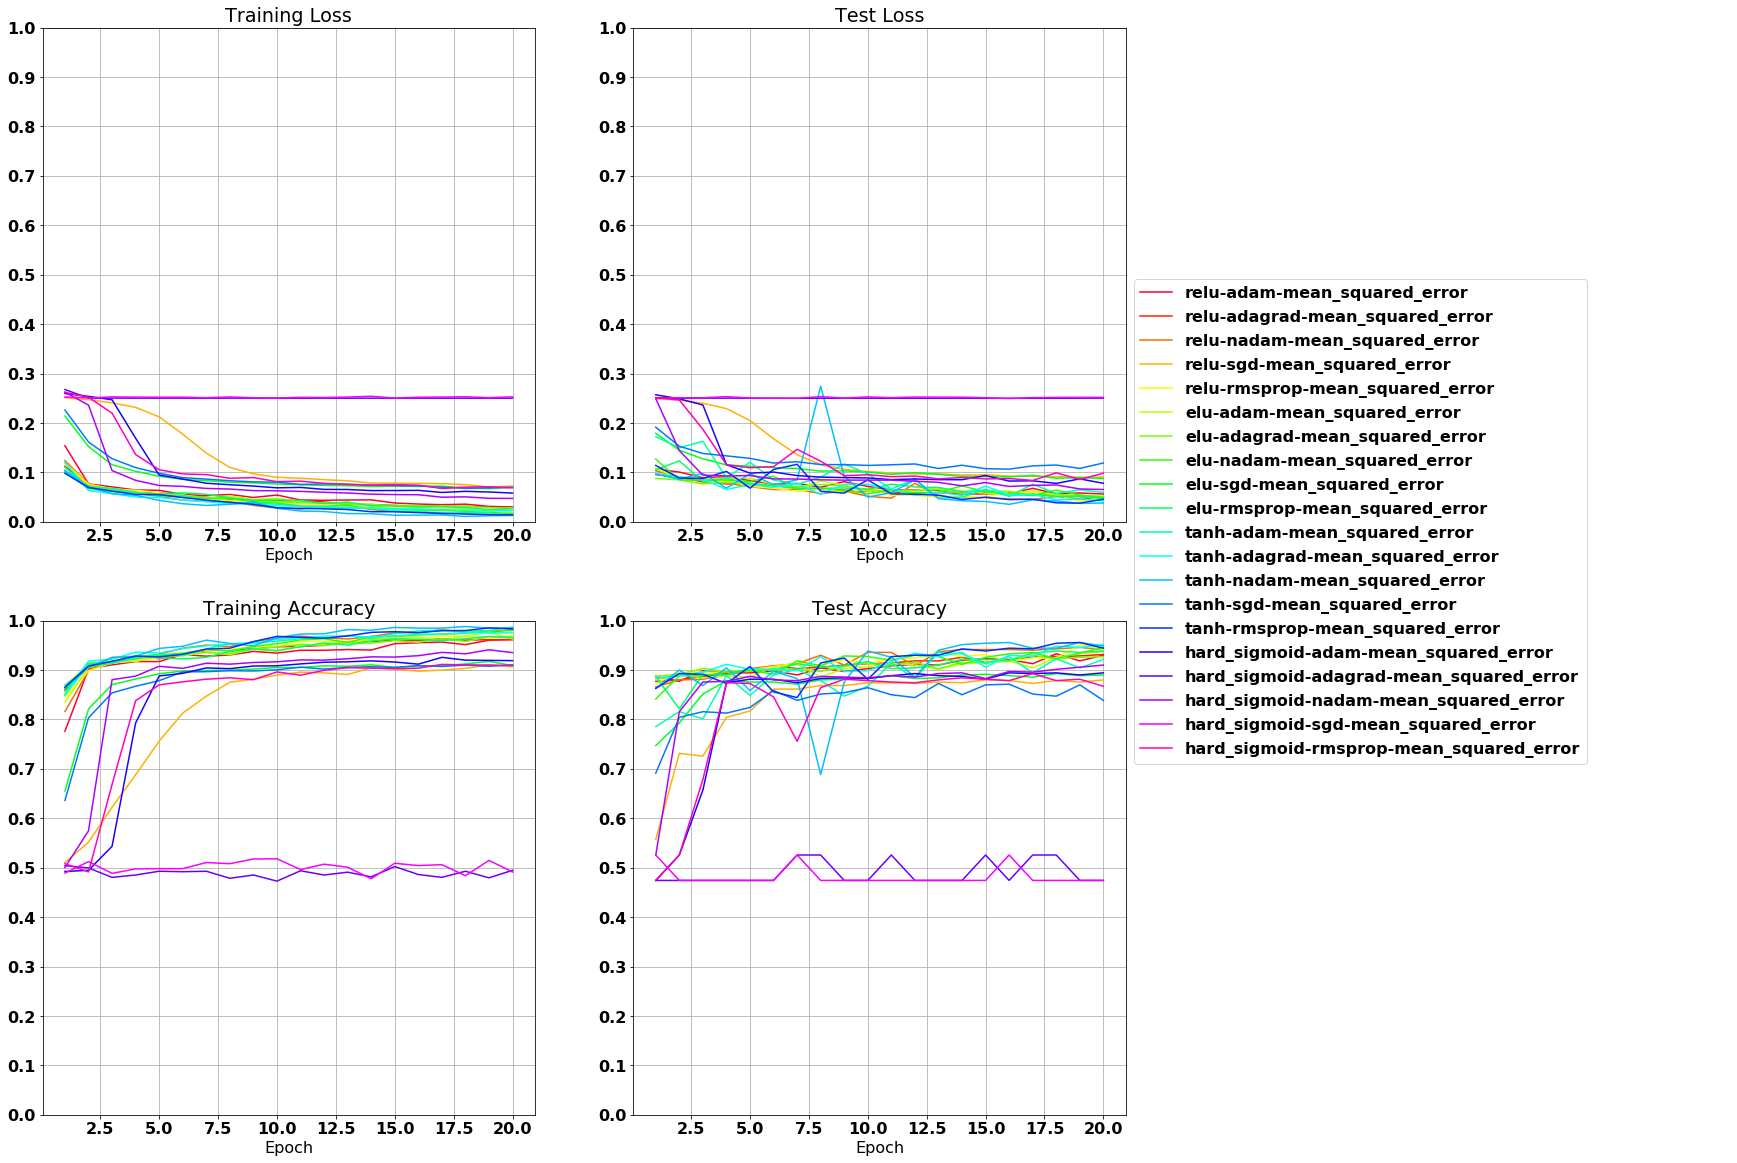

--------------- categorical_hinge ---------------


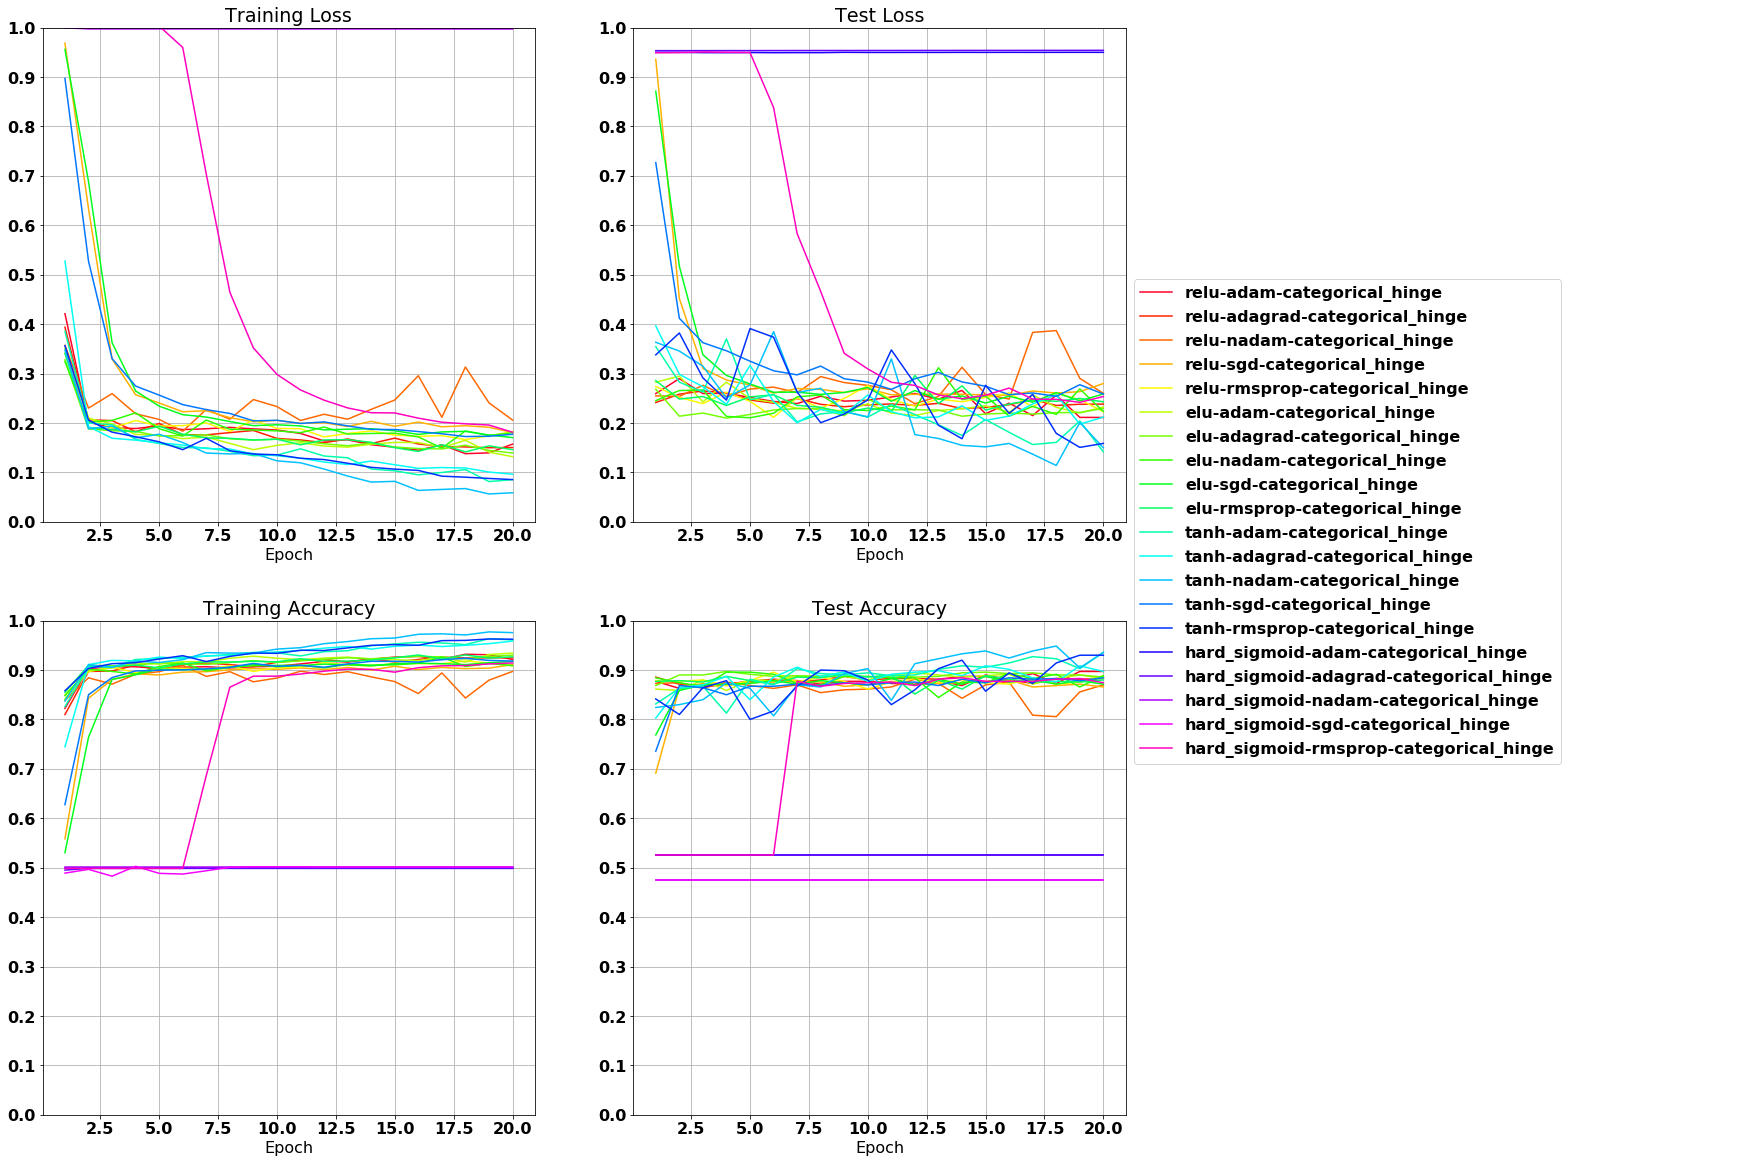

--------------- Activation groups ---------------
--------------- relu ---------------


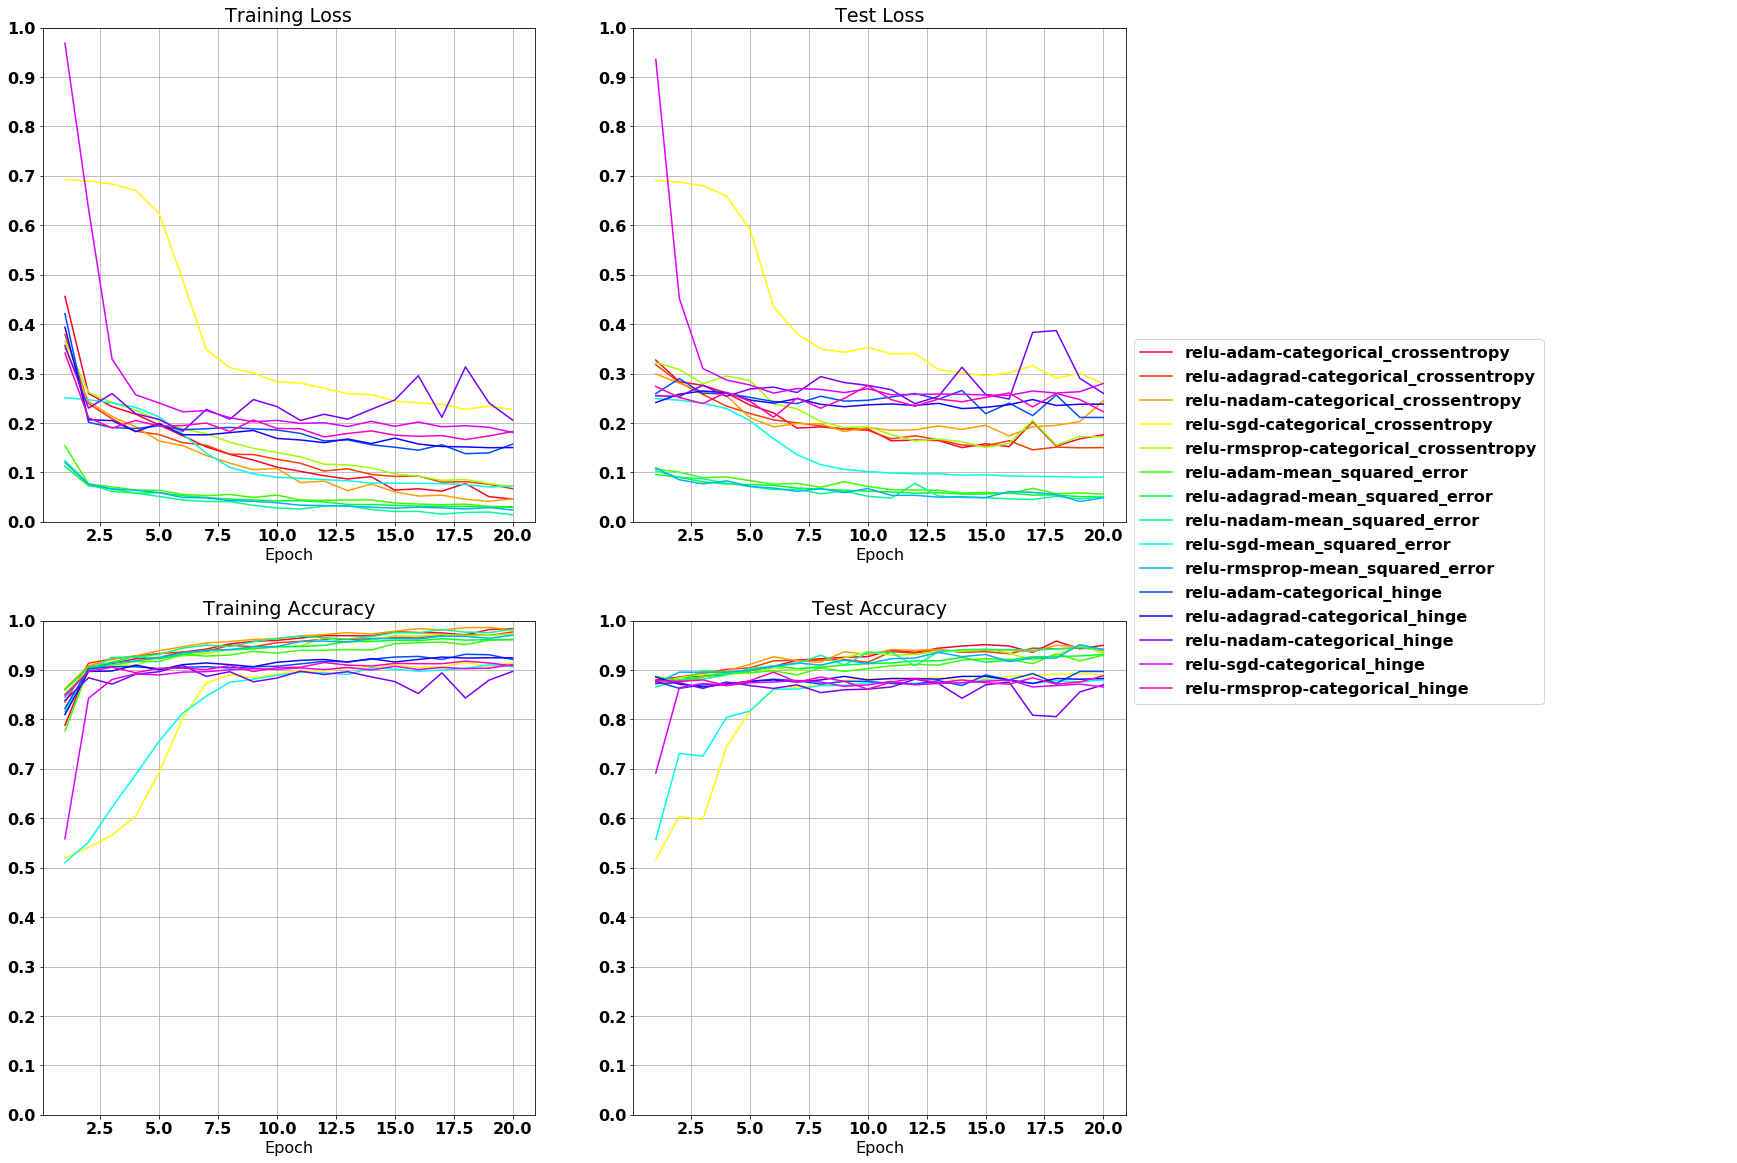

--------------- elu ---------------


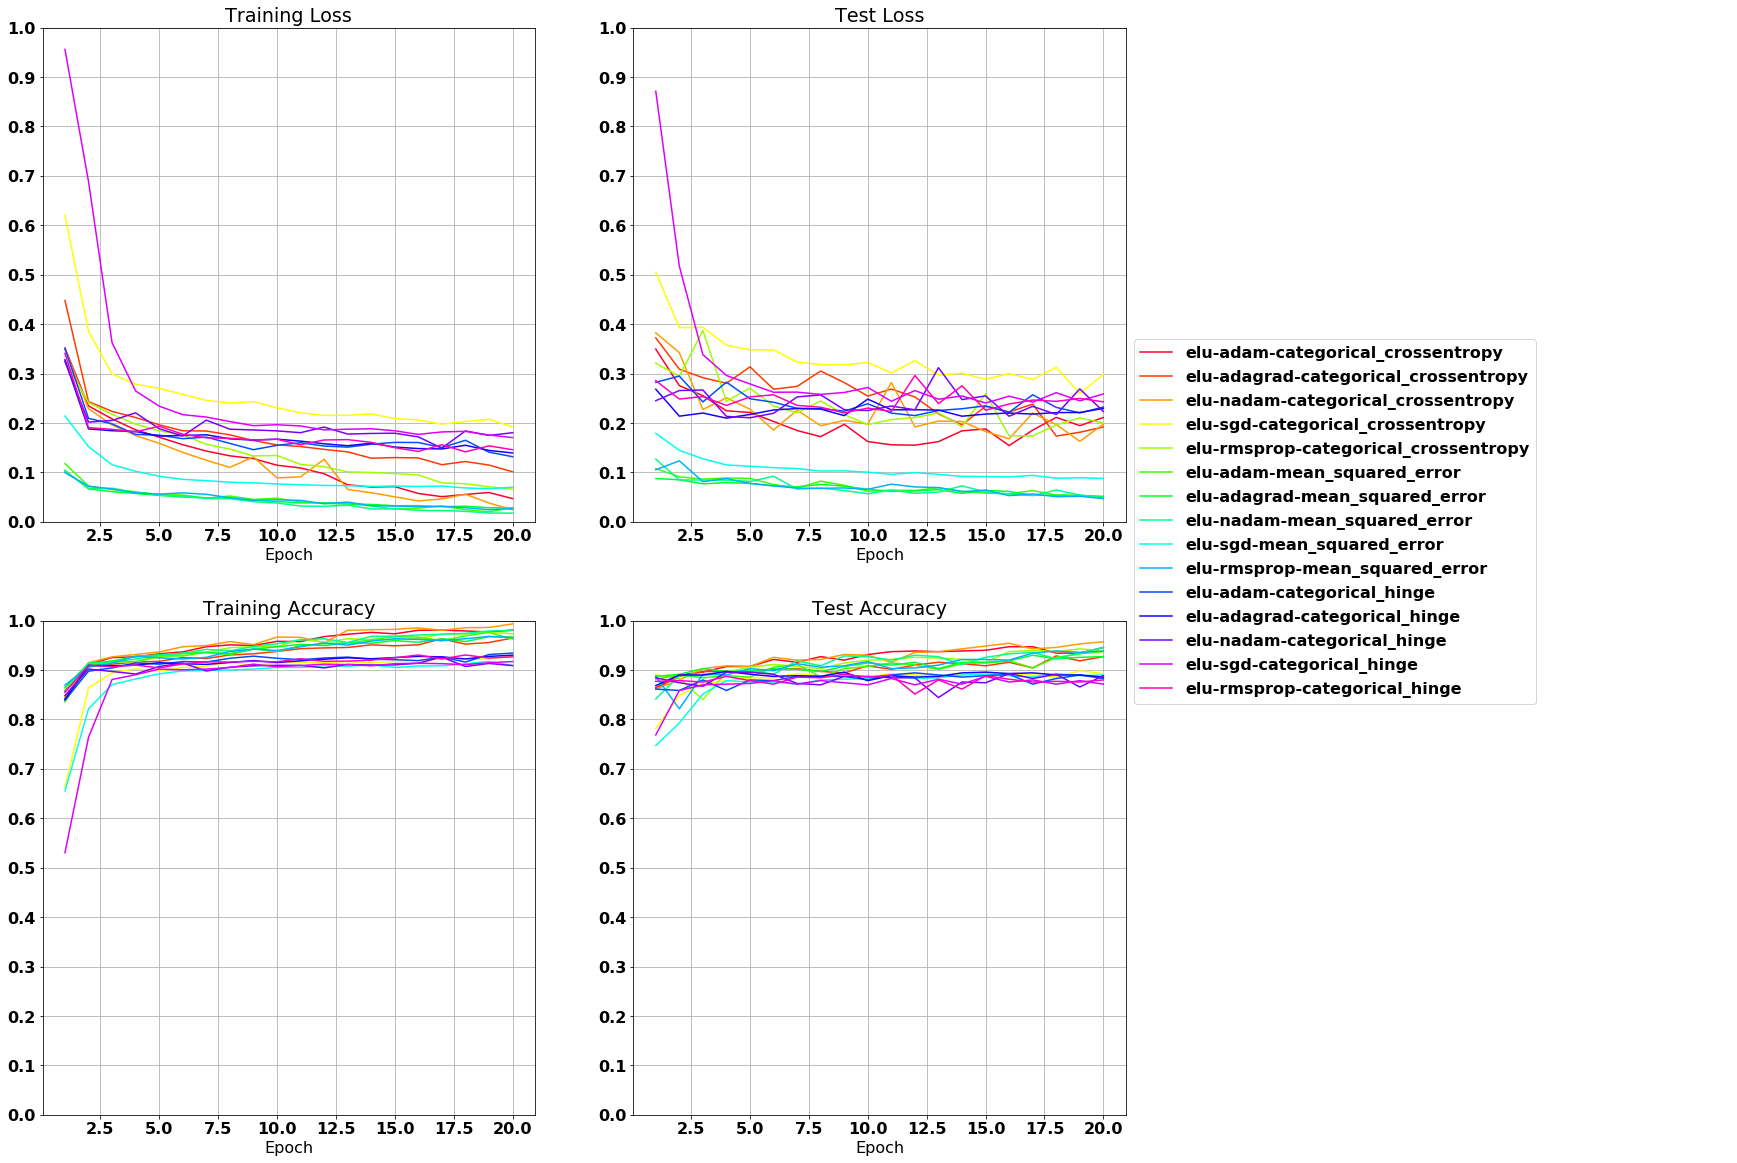

--------------- tanh ---------------


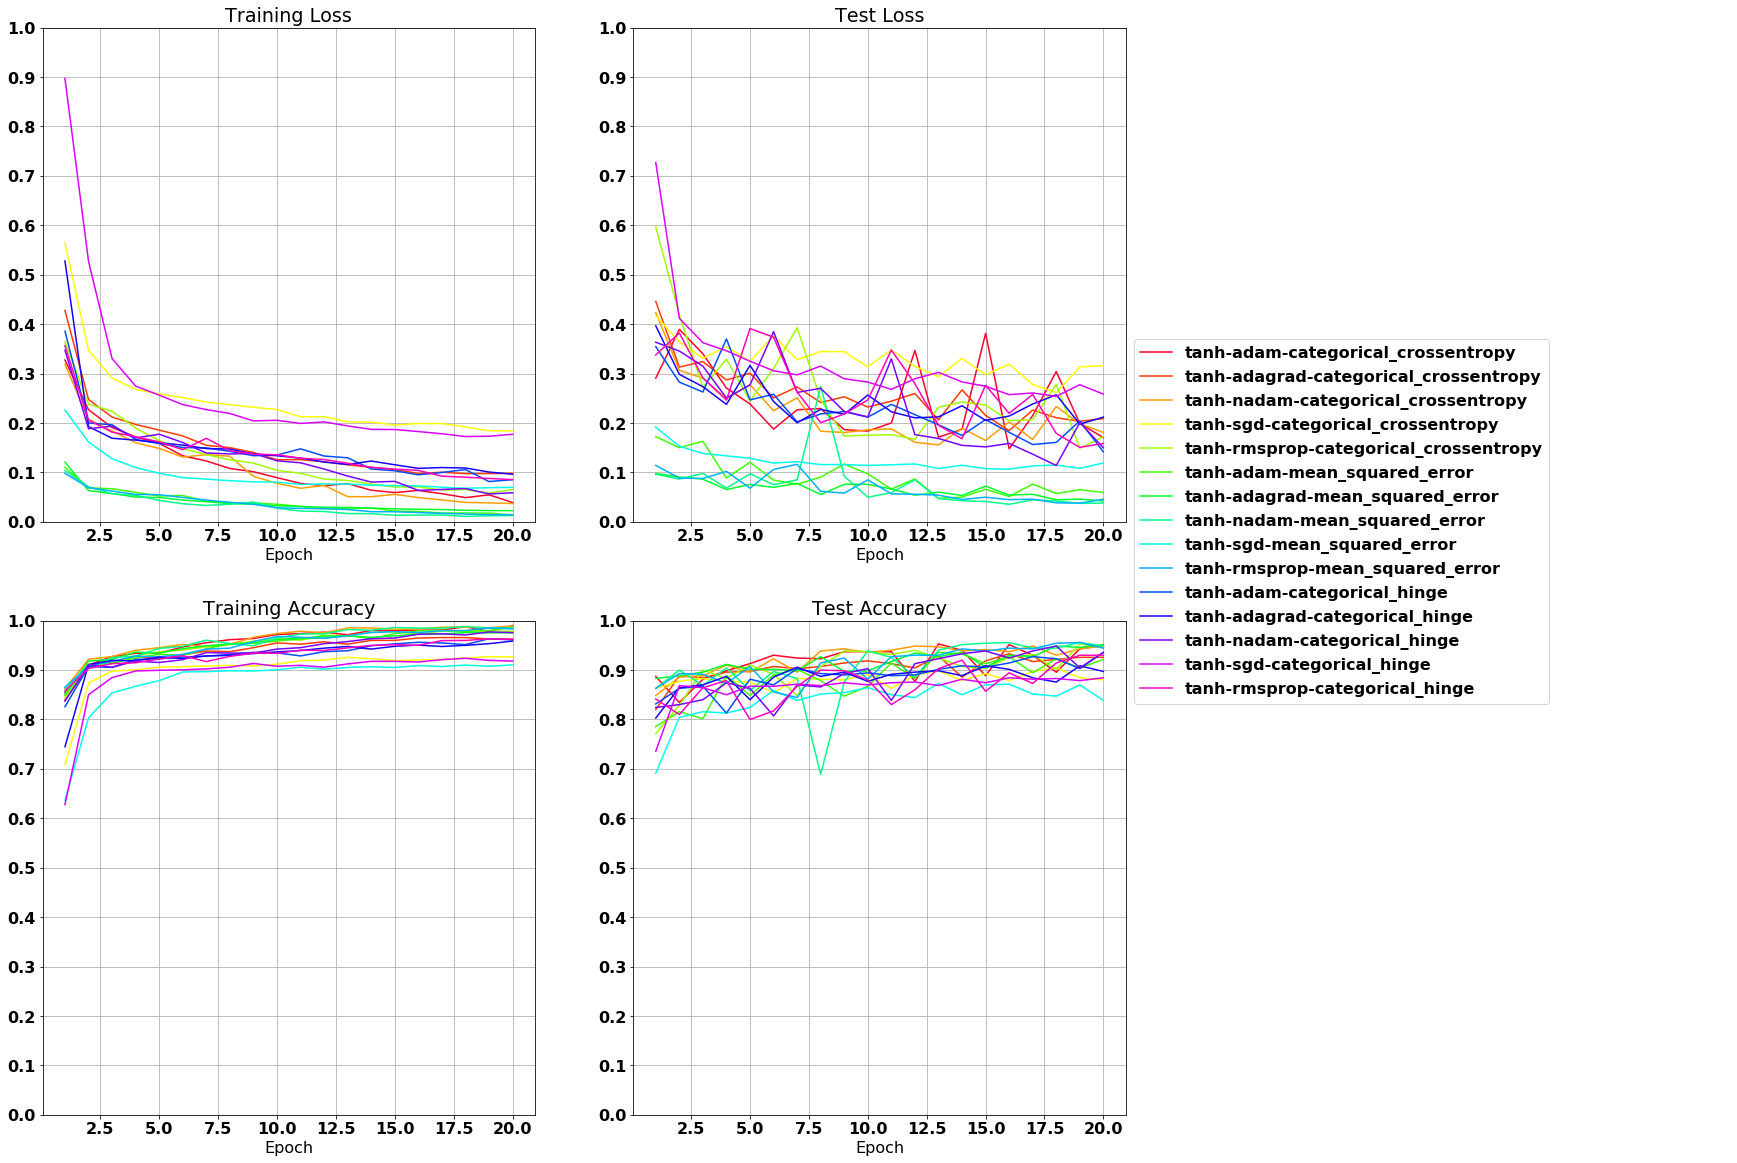

--------------- hard_sigmoid ---------------


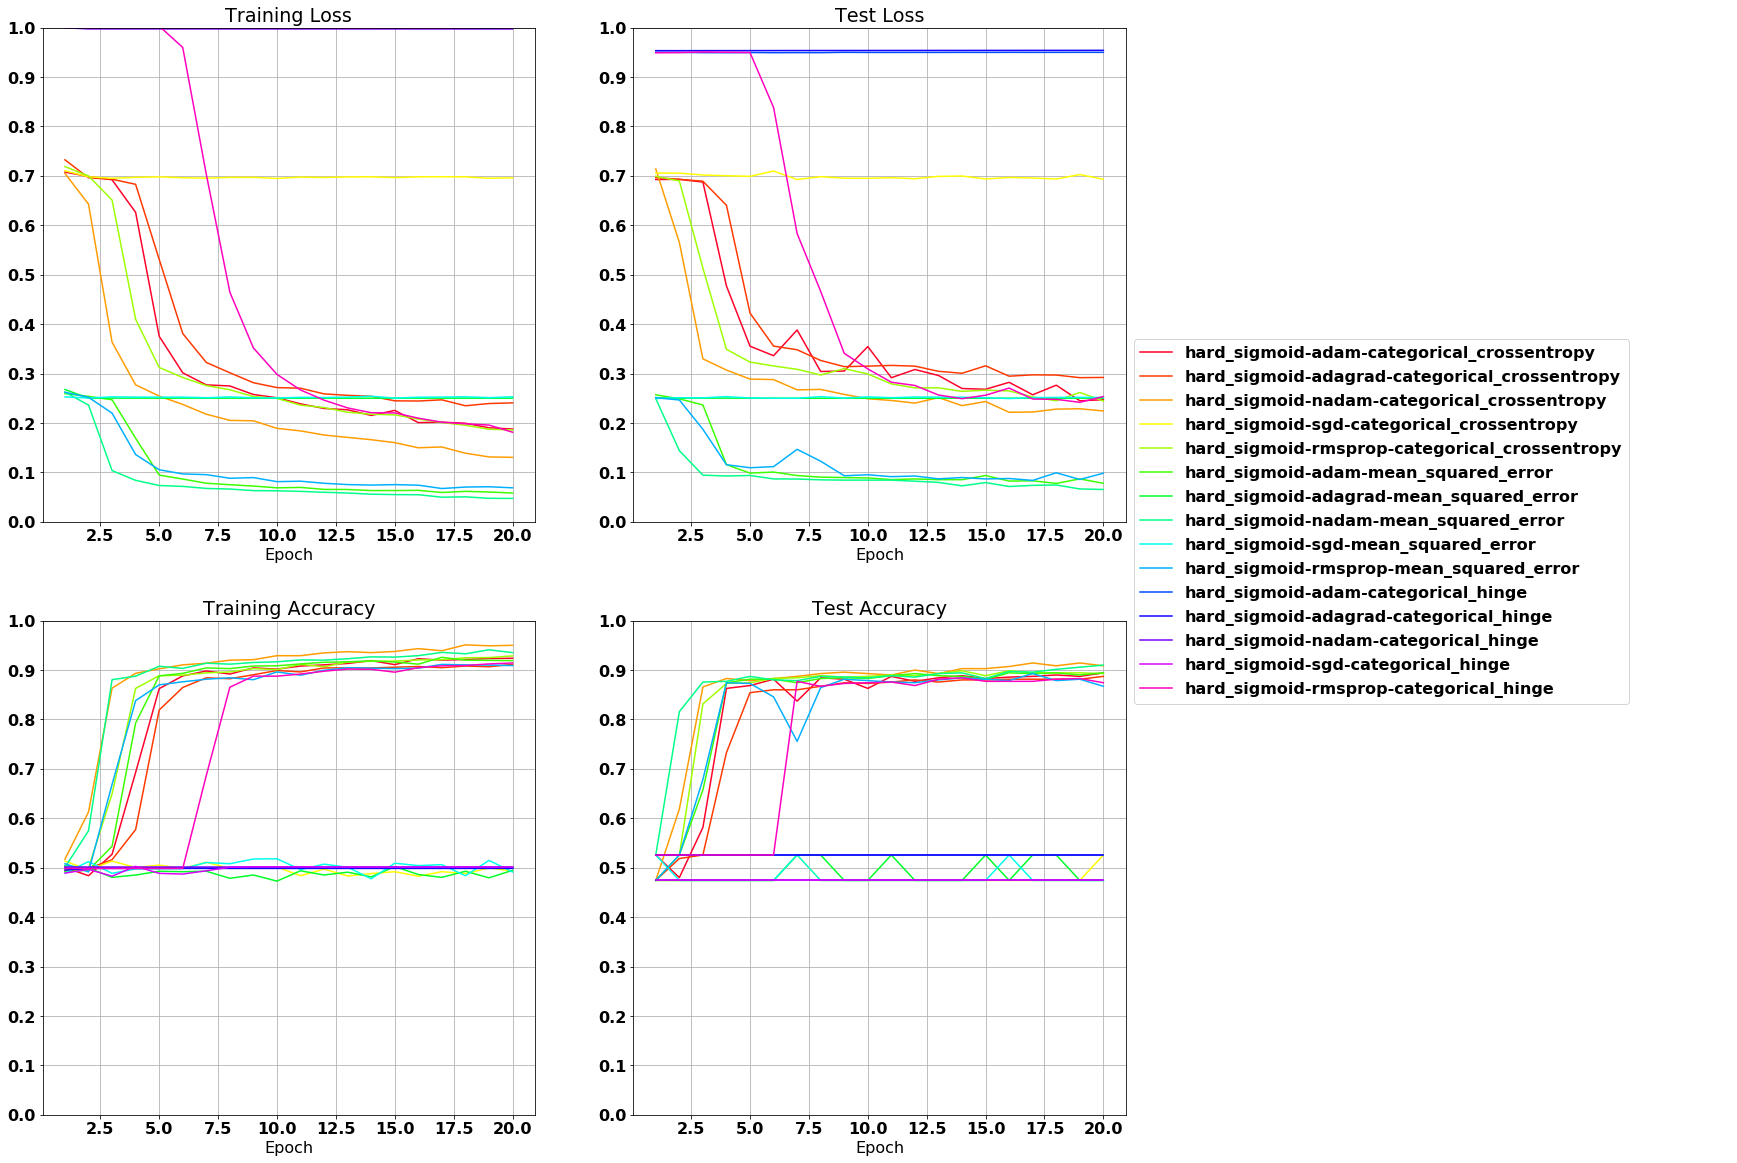

--------------- Optimizer groups ---------------
--------------- adam ---------------


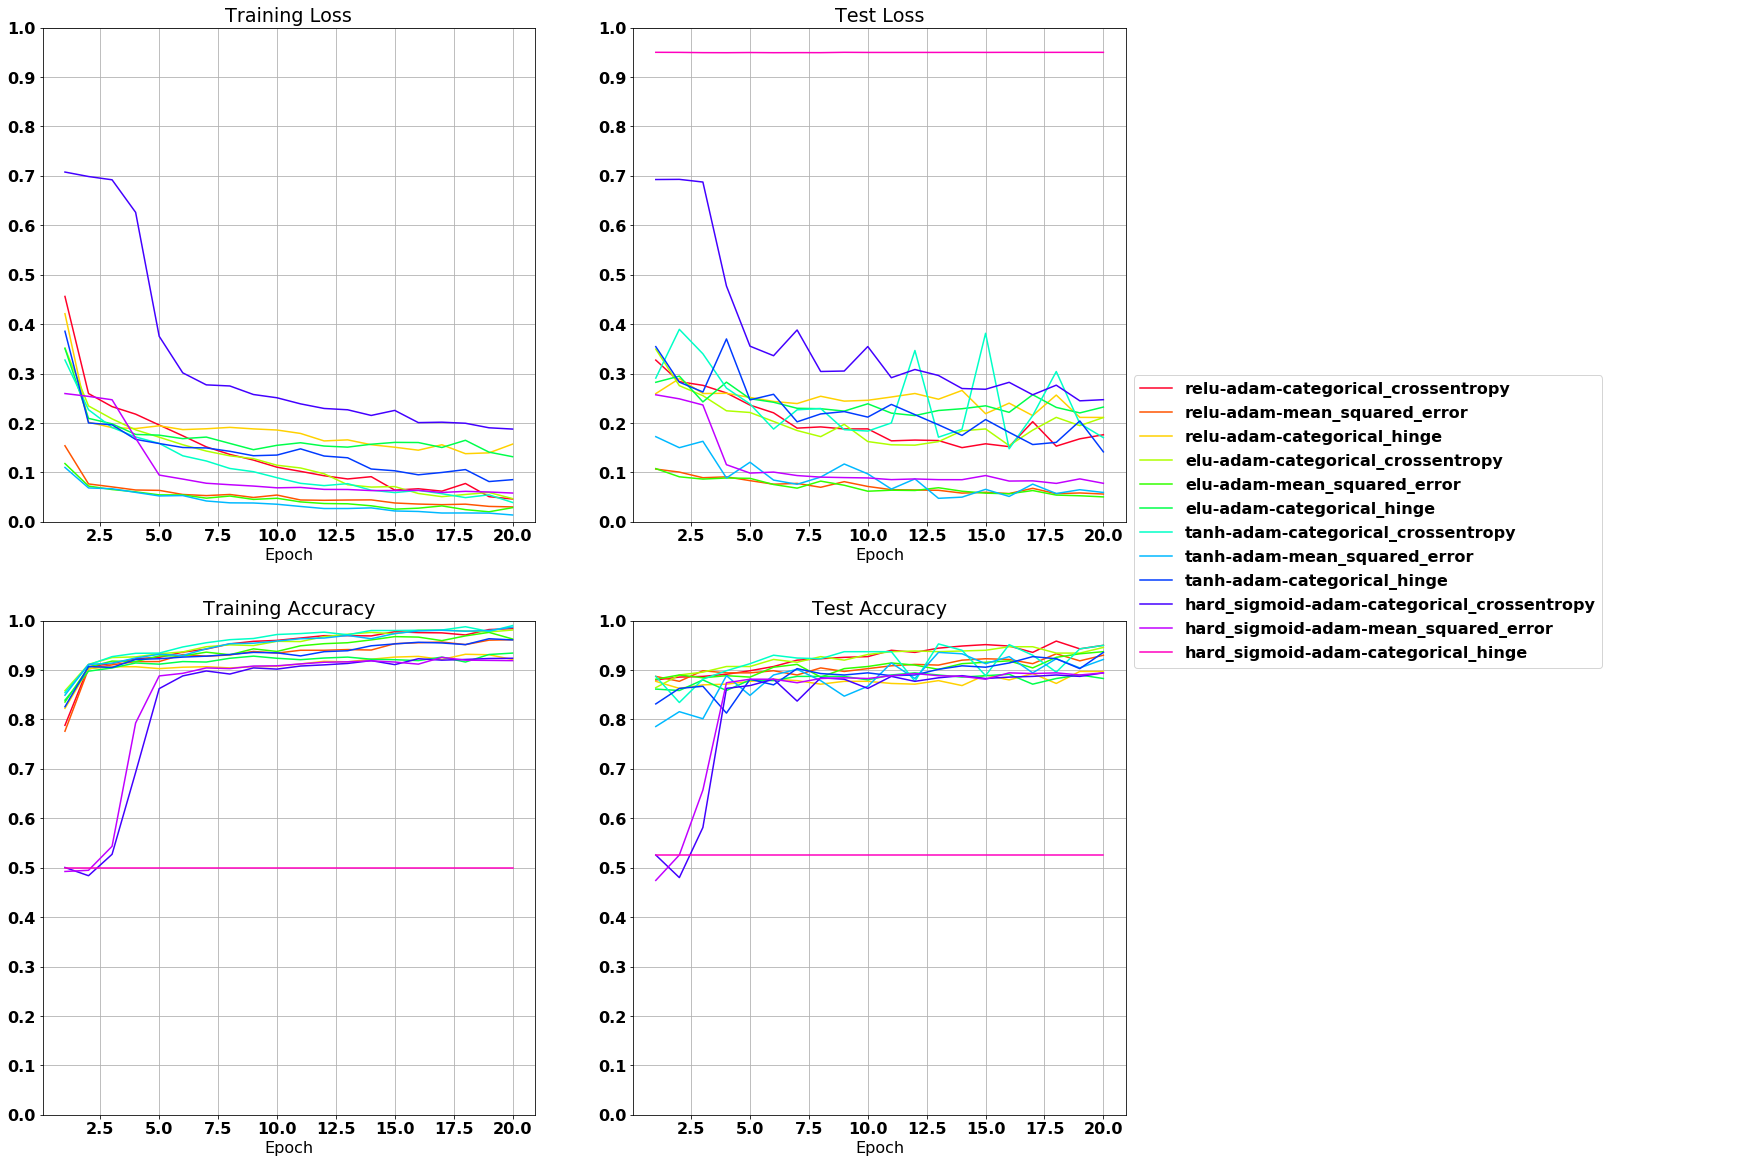

--------------- adagrad ---------------


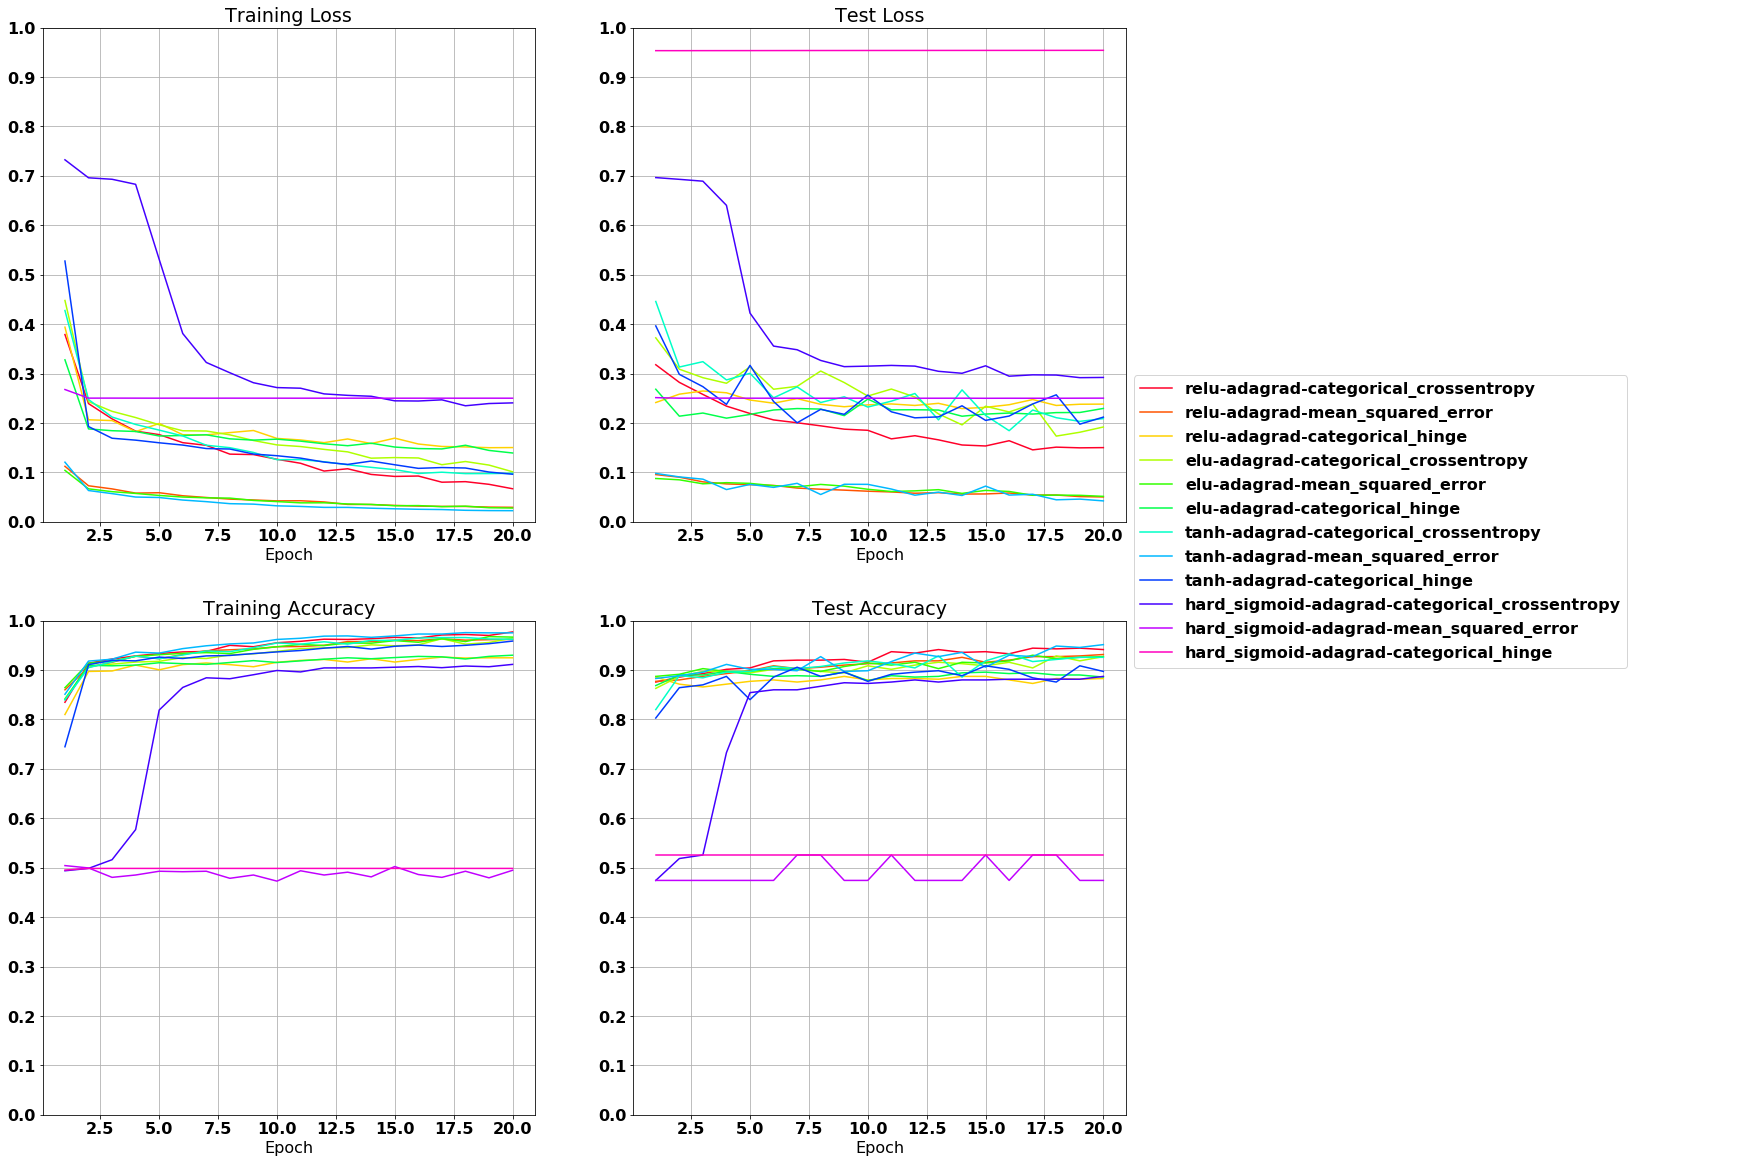

--------------- nadam ---------------


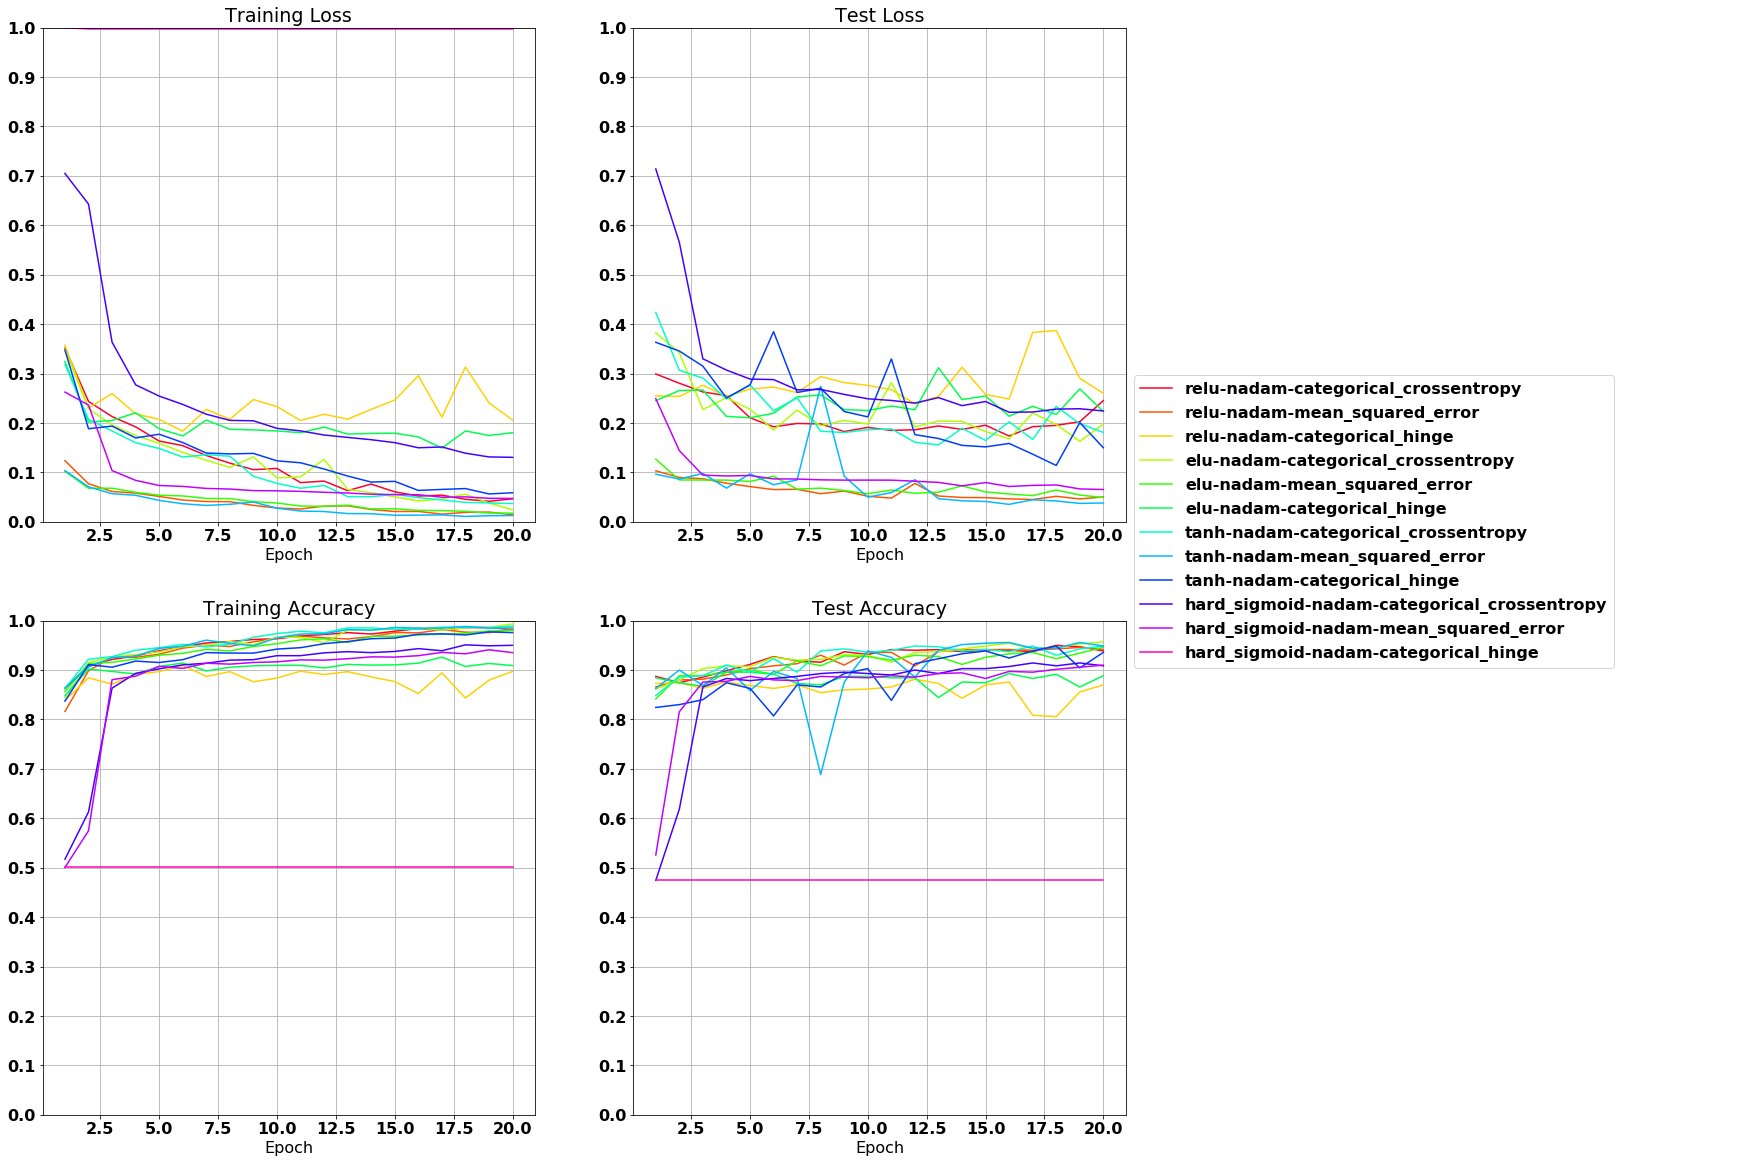

--------------- sgd ---------------


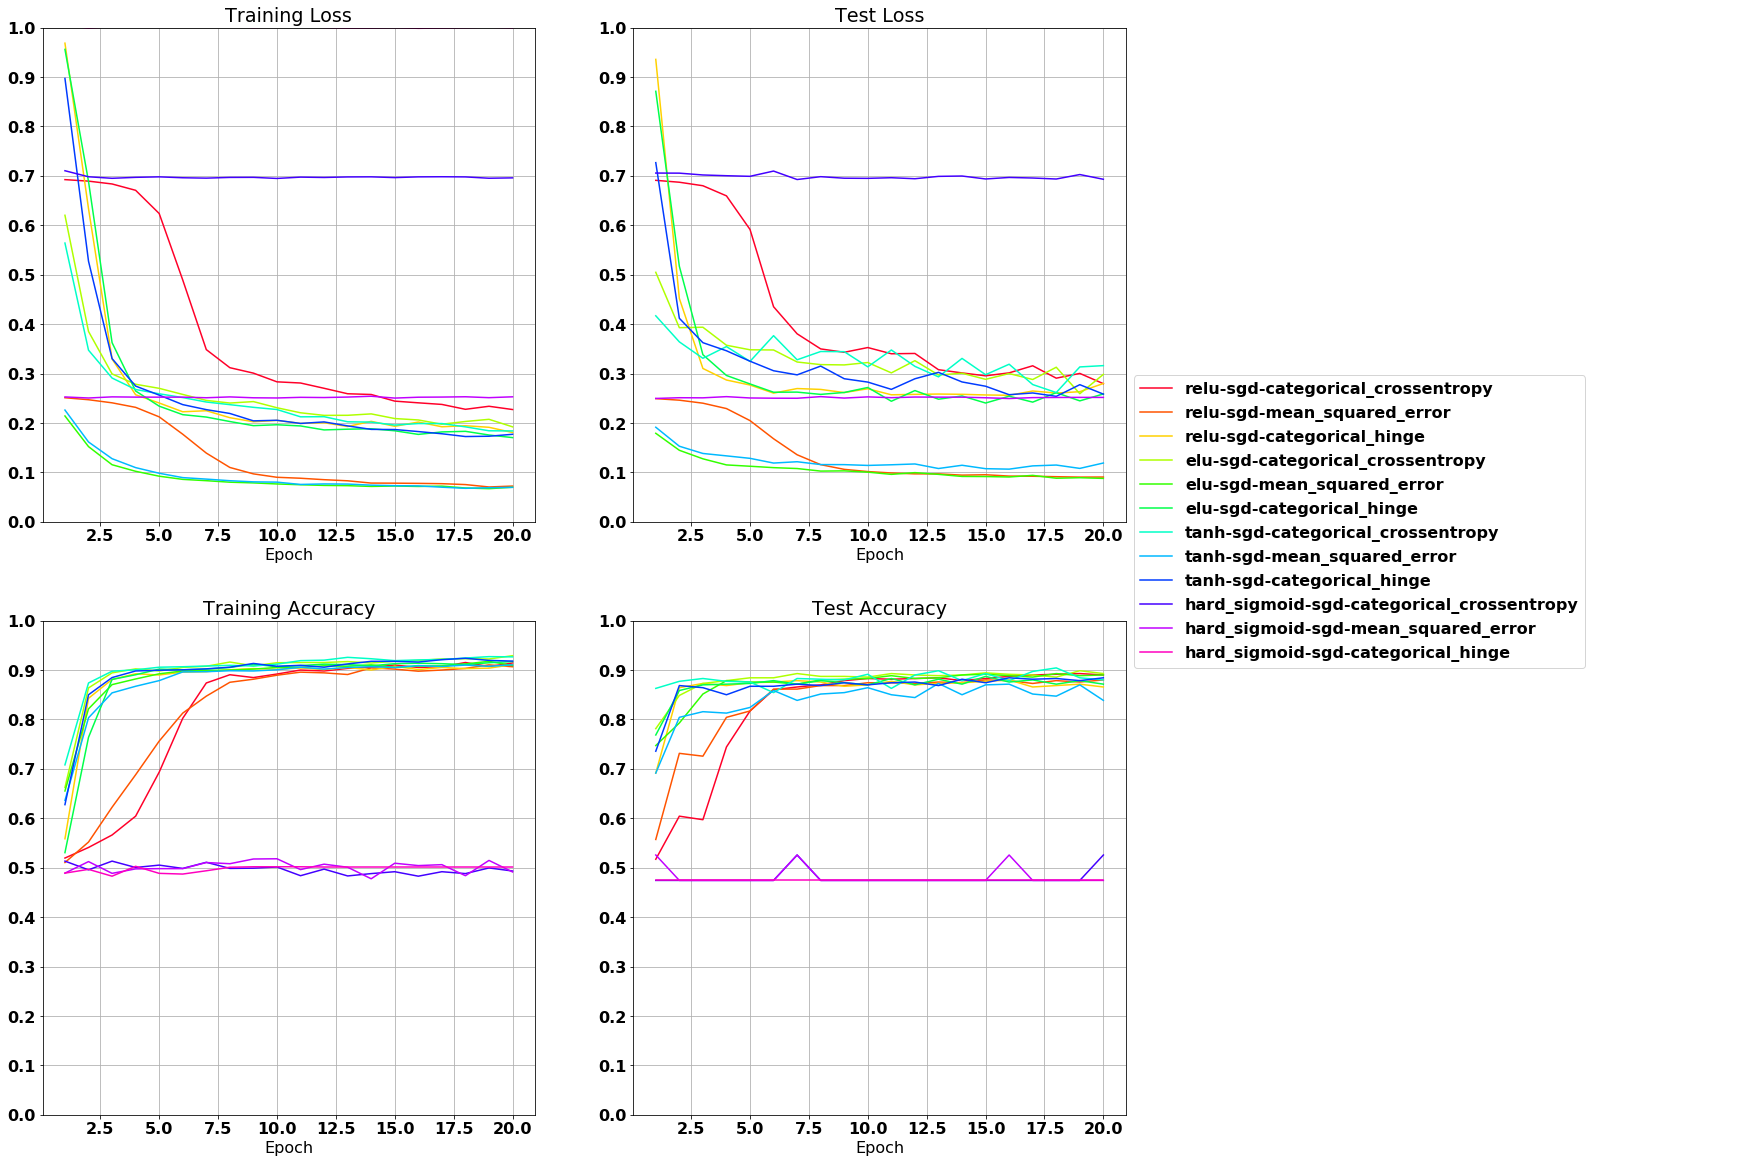

--------------- rmsprop ---------------


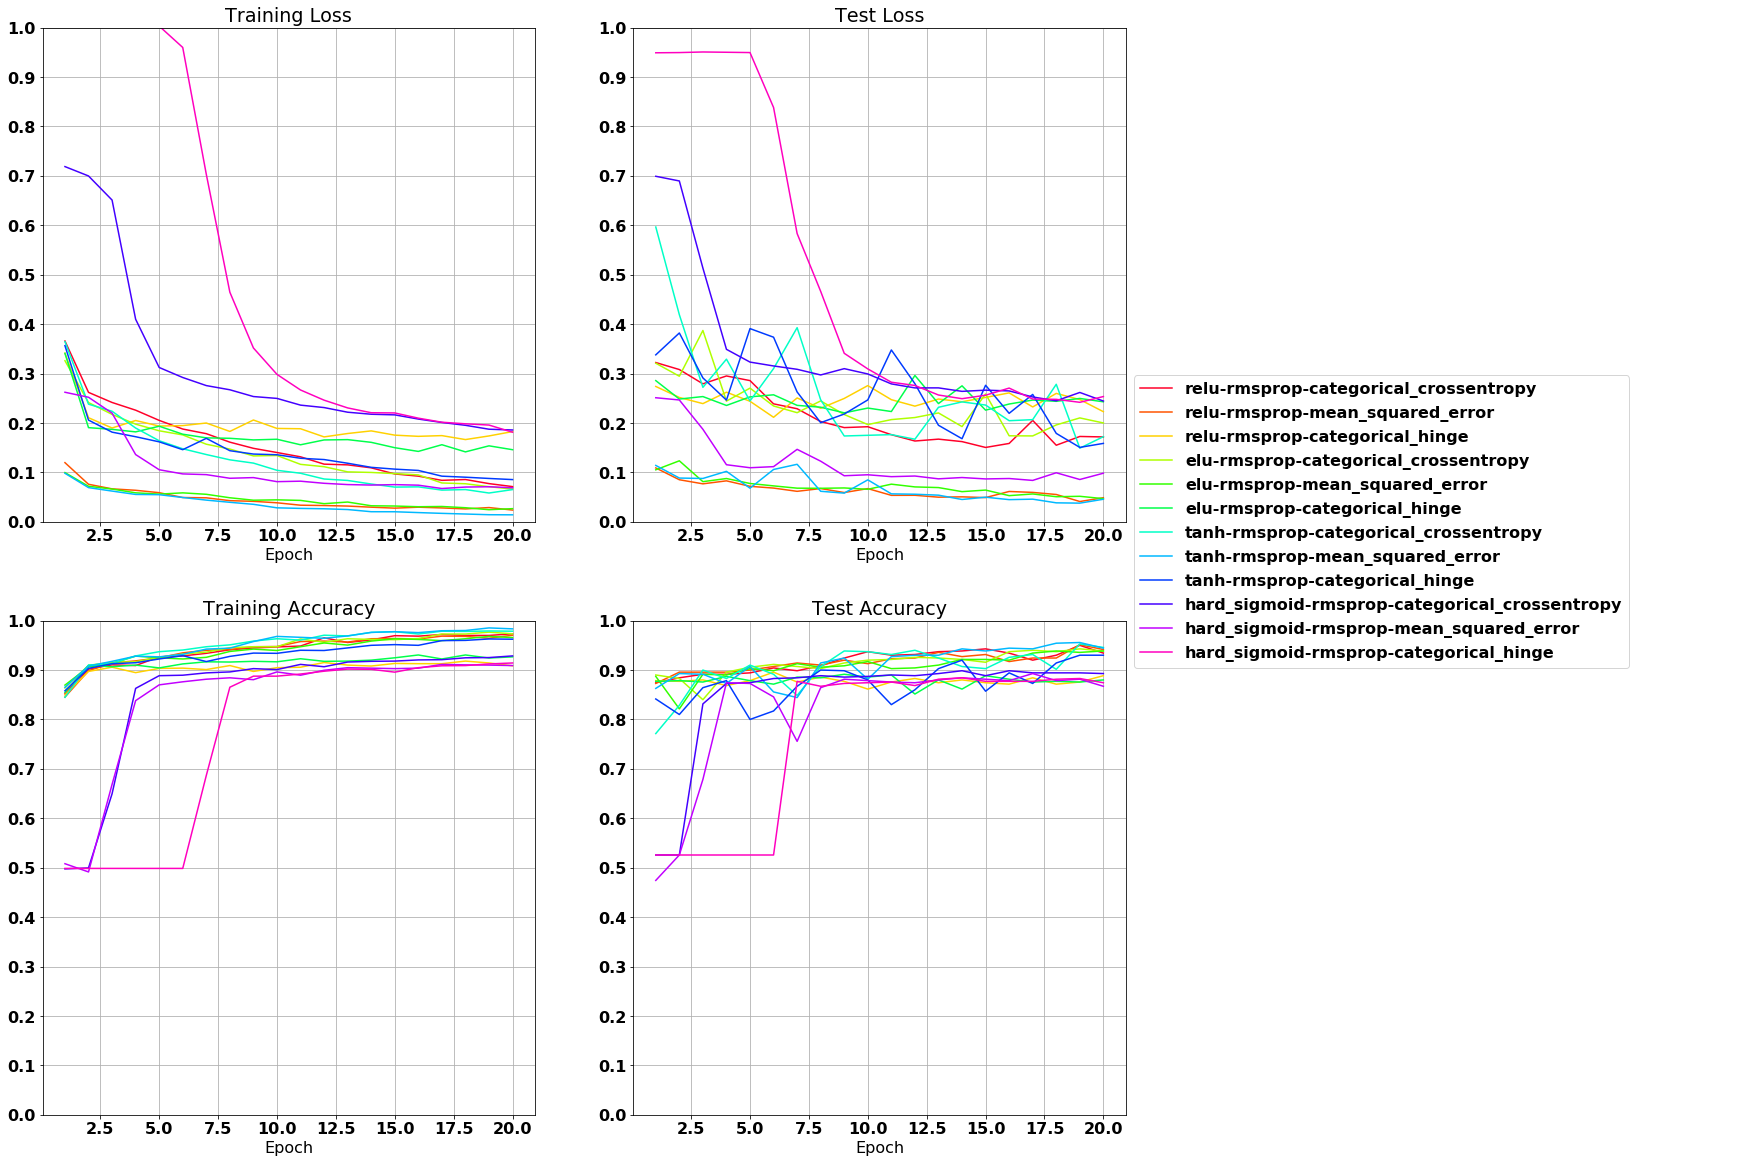

In [417]:
# what to try. Not messing with individual parameters like leaky ReLU or SGD decay
activations = ['relu', 'elu', 'tanh', 'hard_sigmoid']
lossers = ['categorical_crossentropy', 'mean_squared_error', 'categorical_hinge']
optimizers = ['adam', 'adagrad', 'nadam', 'sgd', 'rmsprop']

print('-'*15, 'Loss groups', '-'*15)
# Group plots by loss function
for loss in lossers:
    print('-'*15, loss, '-'*15)
    split_dict = {}
    for activation in activations:
        for optimizer in optimizers:
            key_ = f'{activation}-{optimizer}-{loss}'
            split_dict[key_] = outputs[key_]
    PlotResults(split_dict)

print('-'*15, 'Activation groups', '-'*15)
# Group plots by activation function
for activation in activations:
    print('-'*15, activation, '-'*15)
    split_dict = {}
    for loss in lossers:
        for optimizer in optimizers:
            key_ = f'{activation}-{optimizer}-{loss}'
            split_dict[key_] = outputs[key_]
    PlotResults(split_dict)

print('-'*15, 'Optimizer groups', '-'*15)
# Group plots by optimizer function
for optimizer in optimizers:
    print('-'*15, optimizer, '-'*15)
    split_dict = {}
    for activation in activations:
        for loss in lossers:
            key_ = f'{activation}-{optimizer}-{loss}'
            split_dict[key_] = outputs[key_]
    PlotResults(split_dict)

-------------------- relu-adam-categorical_crossentropy --------------------
Normalized confusion matrix
[[0.93333333 0.06666667]
 [0.01788618 0.98211382]]


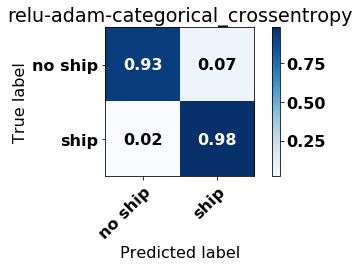

-------------------- relu-adagrad-categorical_crossentropy --------------------
Normalized confusion matrix
[[0.95042735 0.04957265]
 [0.05528455 0.94471545]]


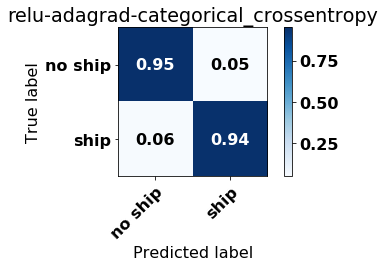

-------------------- relu-nadam-categorical_crossentropy --------------------
Normalized confusion matrix
[[0.91623932 0.08376068]
 [0.02276423 0.97723577]]


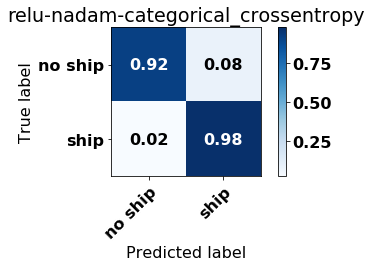

-------------------- relu-sgd-categorical_crossentropy --------------------
Normalized confusion matrix
[[0.88717949 0.11282051]
 [0.08130081 0.91869919]]
False negatives too high! Probably a bad model.
-------------------- relu-rmsprop-categorical_crossentropy --------------------
Normalized confusion matrix
[[0.92136752 0.07863248]
 [0.02276423 0.97723577]]


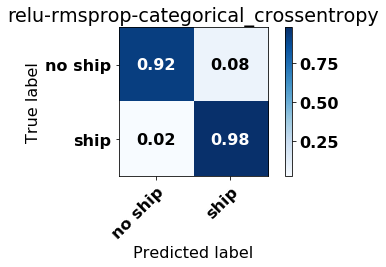

-------------------- relu-adam-mean_squared_error --------------------
Normalized confusion matrix
[[0.94358974 0.05641026]
 [0.04065041 0.95934959]]


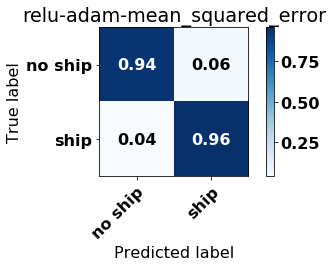

-------------------- relu-adagrad-mean_squared_error --------------------
Normalized confusion matrix
[[0.94700855 0.05299145]
 [0.0699187  0.9300813 ]]


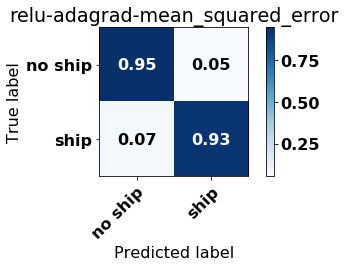

-------------------- relu-nadam-mean_squared_error --------------------
Normalized confusion matrix
[[0.95384615 0.04615385]
 [0.04065041 0.95934959]]


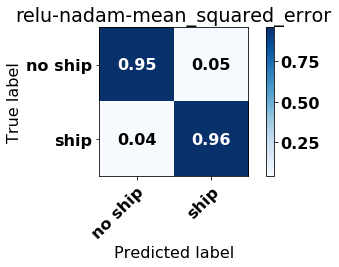

-------------------- relu-sgd-mean_squared_error --------------------
Normalized confusion matrix
[[0.87521368 0.12478632]
 [0.08292683 0.91707317]]
False negatives too high! Probably a bad model.
-------------------- relu-rmsprop-mean_squared_error --------------------
Normalized confusion matrix
[[0.92136752 0.07863248]
 [0.02764228 0.97235772]]


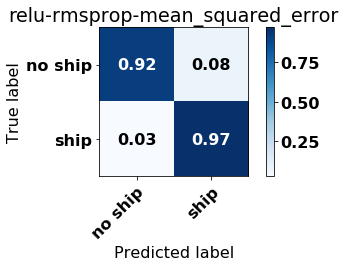

-------------------- relu-adam-categorical_hinge --------------------
Normalized confusion matrix
[[0.91111111 0.08888889]
 [0.09268293 0.90731707]]


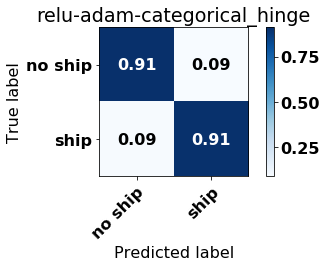

-------------------- relu-adagrad-categorical_hinge --------------------
Normalized confusion matrix
[[0.85299145 0.14700855]
 [0.05203252 0.94796748]]
False negatives too high! Probably a bad model.
-------------------- relu-nadam-categorical_hinge --------------------
Normalized confusion matrix
[[0.85811966 0.14188034]
 [0.08943089 0.91056911]]
False negatives too high! Probably a bad model.
-------------------- relu-sgd-categorical_hinge --------------------
Normalized confusion matrix
[[0.80854701 0.19145299]
 [0.05203252 0.94796748]]
False negatives too high! Probably a bad model.
-------------------- relu-rmsprop-categorical_hinge --------------------
Normalized confusion matrix
[[0.89401709 0.10598291]
 [0.09756098 0.90243902]]
False negatives too high! Probably a bad model.
-------------------- elu-adam-categorical_crossentropy --------------------
Normalized confusion matrix
[[0.94871795 0.05128205]
 [0.04552846 0.95447154]]


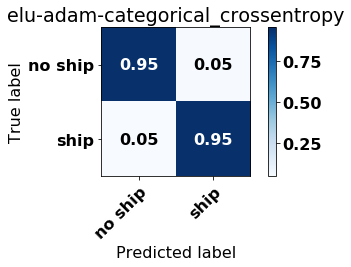

-------------------- elu-adagrad-categorical_crossentropy --------------------
Normalized confusion matrix
[[0.90940171 0.09059829]
 [0.04065041 0.95934959]]


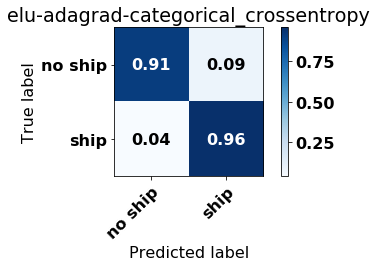

-------------------- elu-nadam-categorical_crossentropy --------------------
Normalized confusion matrix
[[0.95042735 0.04957265]
 [0.03414634 0.96585366]]


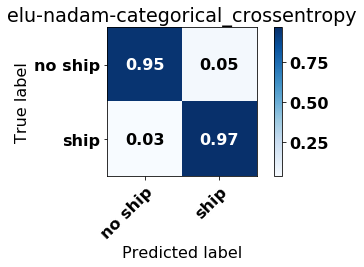

-------------------- elu-sgd-categorical_crossentropy --------------------
Normalized confusion matrix
[[0.84444444 0.15555556]
 [0.03577236 0.96422764]]
False negatives too high! Probably a bad model.
-------------------- elu-rmsprop-categorical_crossentropy --------------------
Normalized confusion matrix
[[0.93162393 0.06837607]
 [0.03252033 0.96747967]]


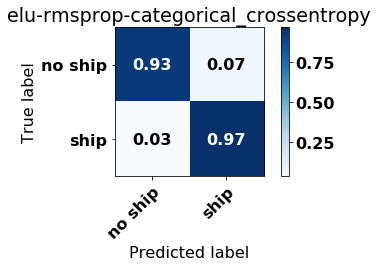

-------------------- elu-adam-mean_squared_error --------------------
Normalized confusion matrix
[[0.95555556 0.04444444]
 [0.07479675 0.92520325]]


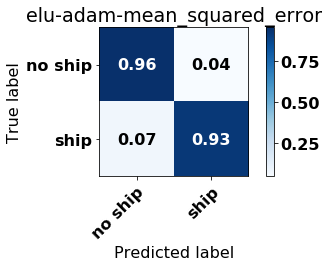

-------------------- elu-adagrad-mean_squared_error --------------------
Normalized confusion matrix
[[0.93162393 0.06837607]
 [0.04065041 0.95934959]]


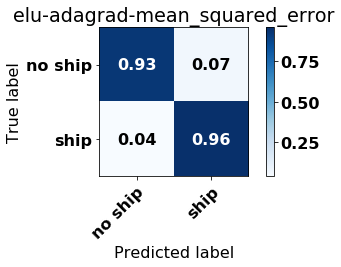

-------------------- elu-nadam-mean_squared_error --------------------
Normalized confusion matrix
[[0.93846154 0.06153846]
 [0.03902439 0.96097561]]


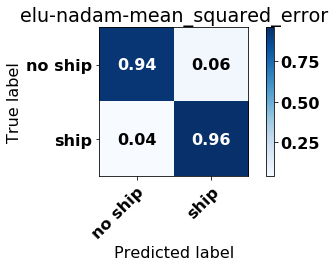

-------------------- elu-sgd-mean_squared_error --------------------
Normalized confusion matrix
[[0.84444444 0.15555556]
 [0.05853659 0.94146341]]
False negatives too high! Probably a bad model.
-------------------- elu-rmsprop-mean_squared_error --------------------
Normalized confusion matrix
[[0.96068376 0.03931624]
 [0.07317073 0.92682927]]


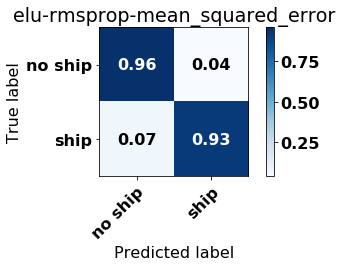

-------------------- elu-adam-categorical_hinge --------------------
Normalized confusion matrix
[[0.86495726 0.13504274]
 [0.03902439 0.96097561]]
False negatives too high! Probably a bad model.
-------------------- elu-adagrad-categorical_hinge --------------------
Normalized confusion matrix
[[0.86666667 0.13333333]
 [0.05853659 0.94146341]]
False negatives too high! Probably a bad model.
-------------------- elu-nadam-categorical_hinge --------------------
Normalized confusion matrix
[[0.85470085 0.14529915]
 [0.06341463 0.93658537]]
False negatives too high! Probably a bad model.
-------------------- elu-sgd-categorical_hinge --------------------
Normalized confusion matrix
[[0.85128205 0.14871795]
 [0.06341463 0.93658537]]
False negatives too high! Probably a bad model.
-------------------- elu-rmsprop-categorical_hinge --------------------
Normalized confusion matrix
[[0.82393162 0.17606838]
 [0.02926829 0.97073171]]
False negatives too high! Probably a bad model.
--------------

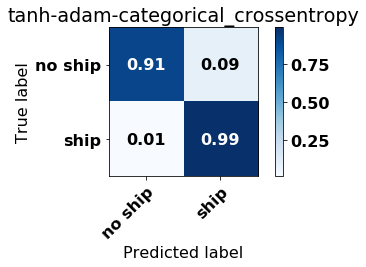

-------------------- tanh-adagrad-categorical_crossentropy --------------------
Normalized confusion matrix
[[0.88205128 0.11794872]
 [0.01463415 0.98536585]]
False negatives too high! Probably a bad model.
-------------------- tanh-nadam-categorical_crossentropy --------------------
Normalized confusion matrix
[[0.92307692 0.07692308]
 [0.01626016 0.98373984]]


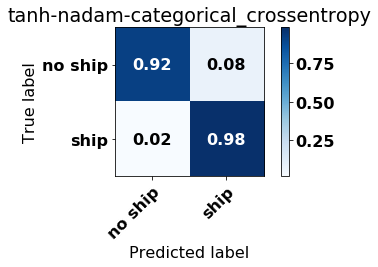

-------------------- tanh-sgd-categorical_crossentropy --------------------
Normalized confusion matrix
[[0.79487179 0.20512821]
 [0.03252033 0.96747967]]
False negatives too high! Probably a bad model.
-------------------- tanh-rmsprop-categorical_crossentropy --------------------
Normalized confusion matrix
[[0.9042735  0.0957265 ]
 [0.00813008 0.99186992]]


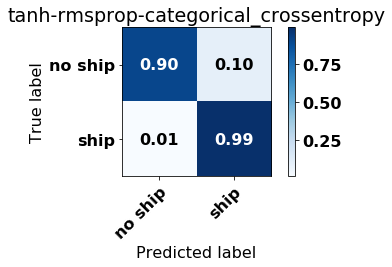

-------------------- tanh-adam-mean_squared_error --------------------
Normalized confusion matrix
[[0.88034188 0.11965812]
 [0.0195122  0.9804878 ]]
False negatives too high! Probably a bad model.
-------------------- tanh-adagrad-mean_squared_error --------------------
Normalized confusion matrix
[[0.91965812 0.08034188]
 [0.0195122  0.9804878 ]]


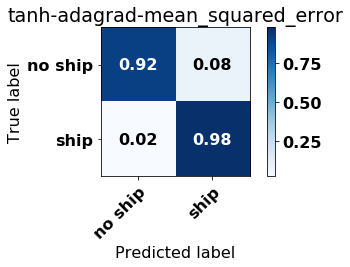

-------------------- tanh-nadam-mean_squared_error --------------------
Normalized confusion matrix
[[0.92478632 0.07521368]
 [0.02439024 0.97560976]]


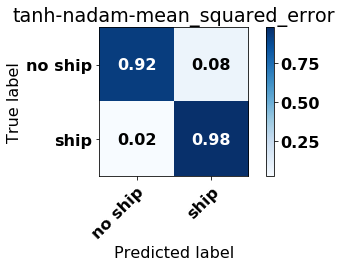

-------------------- tanh-sgd-mean_squared_error --------------------
Normalized confusion matrix
[[0.71794872 0.28205128]
 [0.03739837 0.96260163]]
False negatives too high! Probably a bad model.
-------------------- tanh-rmsprop-mean_squared_error --------------------
Normalized confusion matrix
[[0.8974359  0.1025641 ]
 [0.01300813 0.98699187]]
False negatives too high! Probably a bad model.
-------------------- tanh-adam-categorical_hinge --------------------
Normalized confusion matrix
[[0.9025641  0.0974359 ]
 [0.02926829 0.97073171]]


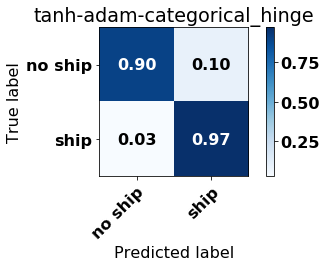

-------------------- tanh-adagrad-categorical_hinge --------------------
Normalized confusion matrix
[[0.84102564 0.15897436]
 [0.0195122  0.9804878 ]]
False negatives too high! Probably a bad model.
-------------------- tanh-nadam-categorical_hinge --------------------
Normalized confusion matrix
[[0.88034188 0.11965812]
 [0.02764228 0.97235772]]
False negatives too high! Probably a bad model.
-------------------- tanh-sgd-categorical_hinge --------------------
Normalized confusion matrix
[[0.82393162 0.17606838]
 [0.04552846 0.95447154]]
False negatives too high! Probably a bad model.
-------------------- tanh-rmsprop-categorical_hinge --------------------
Normalized confusion matrix
[[0.87179487 0.12820513]
 [0.02276423 0.97723577]]
False negatives too high! Probably a bad model.
-------------------- hard_sigmoid-adam-categorical_crossentropy --------------------
Normalized confusion matrix
[[0.8957265  0.1042735 ]
 [0.06829268 0.93170732]]
False negatives too high! Probably a bad m

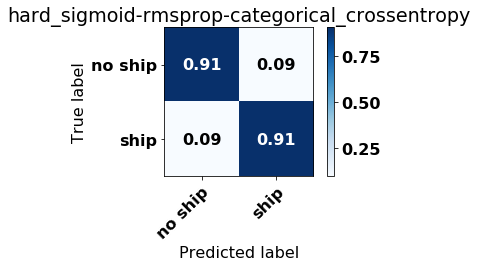

-------------------- hard_sigmoid-adam-mean_squared_error --------------------
Normalized confusion matrix
[[0.8957265  0.1042735 ]
 [0.07154472 0.92845528]]
False negatives too high! Probably a bad model.
-------------------- hard_sigmoid-adagrad-mean_squared_error --------------------
Normalized confusion matrix
[[0. 1.]
 [0. 1.]]
False negatives too high! Probably a bad model.
-------------------- hard_sigmoid-nadam-mean_squared_error --------------------
Normalized confusion matrix
[[0.92136752 0.07863248]
 [0.06829268 0.93170732]]


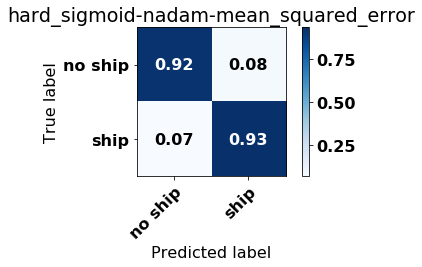

-------------------- hard_sigmoid-sgd-mean_squared_error --------------------
Normalized confusion matrix
[[0. 1.]
 [0. 1.]]
False negatives too high! Probably a bad model.
-------------------- hard_sigmoid-rmsprop-mean_squared_error --------------------
Normalized confusion matrix
[[0.83418803 0.16581197]
 [0.04390244 0.95609756]]
False negatives too high! Probably a bad model.
-------------------- hard_sigmoid-adam-categorical_hinge --------------------
Normalized confusion matrix
[[1. 0.]
 [1. 0.]]
False positives too high! Probably a bad model.
-------------------- hard_sigmoid-adagrad-categorical_hinge --------------------
Normalized confusion matrix
[[1. 0.]
 [1. 0.]]
False positives too high! Probably a bad model.
-------------------- hard_sigmoid-nadam-categorical_hinge --------------------
Normalized confusion matrix
[[0. 1.]
 [0. 1.]]
False negatives too high! Probably a bad model.
-------------------- hard_sigmoid-sgd-categorical_hinge --------------------
Normalized confusi

In [505]:
success_dict = EvaluateAndPlot(outputs, X_test, y_test)

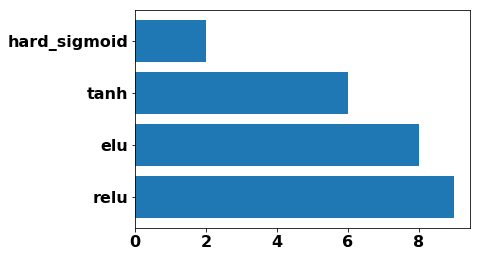

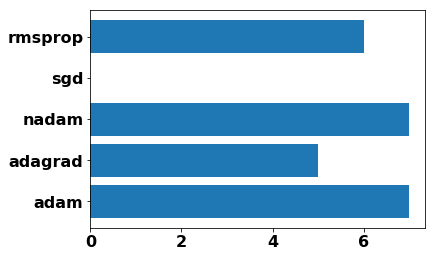

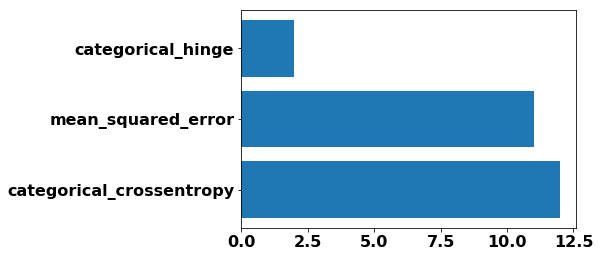

In [564]:
success_dicts = success_dict
for dict_ in success_dicts:
    plt.figure()
    plt.barh(range(len(dict_)), list(dict_.values()), align='center')
    plt.yticks(range(len(dict_)), list(dict_.keys()))

In [550]:
success_dict

({'relu': 9, 'elu': 8, 'tanh': 6, 'hard_sigmoid': 2},
 {'adam': 7, 'adagrad': 5, 'nadam': 7, 'sgd': 0, 'rmsprop': 6},
 {'categorical_crossentropy': 12,
  'mean_squared_error': 11,
  'categorical_hinge': 2})

In [592]:
X2_train, X2_test, y2_train, y2_test = GenSplitNorm(data, labels, generate=False)

-------------------- this --------------------
Normalized confusion matrix
[[0.98809524 0.01190476]
 [0.00943396 0.99056604]]


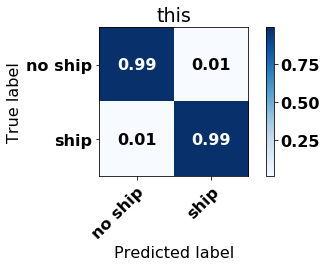

In [605]:
success_dict = EvaluateAndPlot({'this':singleton}, X2_test, y2_test, count=False)

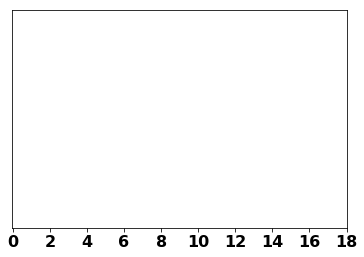

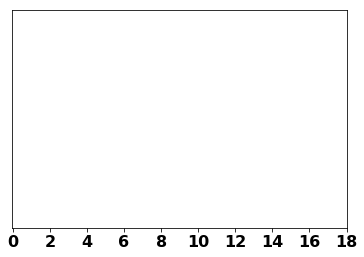

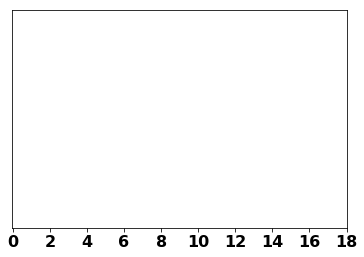

In [606]:
success_dicts = success_dict
for dict_ in success_dicts:
    plt.figure()
    plt.barh(range(len(dict_)), list(dict_.values()), align='center')
    plt.yticks(range(len(dict_)), list(dict_.keys()))
    plt.xticks(range(0, 20, 2))